# Home Credit Default Risk (HCDR)

The course project is based on the [Home Credit Default Risk (HCDR)  Kaggle Competition](https://www.kaggle.com/c/home-credit-default-risk/). The goal of this project is to predict whether or not a client will repay a loan. In order to make sure that people who struggle to get loans due to insufficient or non-existent credit histories have a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

## Some of the challenges

1. Dataset size 
   * (688 meg uncompressed) with millions of rows of data
   * 2.71 Gig of data uncompressed
* Dealing with missing data
* Imbalanced datasets
* Summarizing transaction data
* Merging of the aggregated data

## Team - Group 4
* Ayush Srivastava
* David Drummond
* Ritu Sanjay
* Vishal Bhalla

# Dataset and how to download


## Back ground Home Credit Group

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

### Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.


## Background on the dataset
Home Credit is a non-banking financial institution, founded in 1997 in the Czech Republic.

The company operates in 14 countries (including United States, Russia, Kazahstan, Belarus, China, India) and focuses on lending primarily to people with little or no credit history which will either not obtain loans or became victims of untrustworthly lenders.

Home Credit group has over 29 million customers, total assests of 21 billions Euro, over 160 millions loans, with the majority in Asia and and almost half of them in China (as of 19-05-2018).

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## Data files overview
There are 7 different sources of data:

* __application_train/application_test:__ the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating __0: the loan was repaid__ or __1: the loan was not repaid__. The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.
* __bureau:__ data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* __bureau_balance:__ monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* __previous_application:__ previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* __POS_CASH_BALANCE:__ monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* __credit_card_balance:__ monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment:__ payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

![alt](home_credit.png "Home credit")

### Connect to Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#DATA_DIR = "/content/drive/My Drive/HCDR" # VB: Changed to load from google drive
DATA_DIR = "C:/Users/Ayush/Desktop/sem 4/aml/project/HCRD"

### Imports

In [6]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
#from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import os
import zipfile
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # Allows to display all columns of a DF
'''from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV'''

'from keras.models import Sequential\nfrom keras.layers import Dense\nfrom sklearn.metrics import accuracy_score, confusion_matrix, classification_report\nfrom sklearn.model_selection import RandomizedSearchCV'

### Helper Functions

In [7]:
def data_stats(ds_name):
    df =  datasets[ds_name]
    print("\n",ds_name,"\n")
    col_list=['Unique','NAN','Nan%','MaxVal','MinVal','Mean']
    dfx=pd.DataFrame(index=df.columns,columns=col_list)
    dfx['Unique']= df.apply(lambda x: len(x.unique())) 
    dfx['NAN'] = df.isna().sum()
    dfx['Nan%']= (df.isnull().sum()/df.isnull().count()*100).round(2)
    
    # Loop to find the Max, Min and calculate the mean
    for i,col in enumerate(df.columns):
        if 'float' in str(df[col].dtype) or 'int' in str(df[col].dtype):
            dfx.at[col,'MaxVal']=str(round(df[col].max(),2))
            dfx.at[col,'MinVal']=str(round(df[col].min(),2))
            dfx.at[col,'Mean']=df[col].mean()
    dfx.fillna('-',inplace=True)
    print("\n",dfx,"\n")
    
def day_convert(df):
    col_list = list(df.columns)
    for col in col_list:
        if 'DAYS_' in col:
            df[col]=df[col].abs()
    return df

def load_data(in_path, name):
    df = pd.read_csv(in_path)
    reduce_mem_usage(df)
    print("\n")
    print(f"{name}: shape is {df.shape}")
    display(df.head(5))
    return df

  


# This code has been taken from https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



### Helper Classes

In [8]:
# Dataframe Selector
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #print(len(self.attribute_names))
        #print(len(X.columns))
        return X[self.attribute_names]

# Feature Aggregator
class FeatAggr(BaseEstimator, TransformerMixin):
  def __init__(self, features=None):
    self.features = features
    self.agg_op_features = {}

  def fit(self, X, y=None):
    return self
    
  def transform(self, X, y=None):
    result = X.groupby(['SK_ID_CURR']).agg(['nunique','mean', 'count', 'std', 'sum', 'min', 'max'])
    result.columns = [ '_'.join(str(i) for i in col) for col in result.columns]
    result.reset_index(inplace=True)
    return result
 
#Data Merge
class mergeData(BaseEstimator, TransformerMixin):
  def __init__(self, dflst):
    self.dflst = dflst
      
  def fit(self, X, y=None):
    return self
  
  def transform(self,X, y = None):
    for i in self.dflst:
        X = X.merge(i, how='left', on='SK_ID_CURR')
      
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)
    #X.drop(columns=['SK_ID_CURR'])
    return X

## Data files overview
### Data Dictionary

As part of the data download comes a  Data Dictionary. It named `HomeCredit_columns_description.csv`

![image.png](attachment:image.png)

### Load Data

In [9]:
%%time
datasets={}  # lets store the datasets in a dictionary so we can keep track of them easily

ds_names = ("application_train", "application_test", "bureau", "bureau_balance", "credit_card_balance", "installments_payments", "previous_application", "POS_CASH_balance")

for ds_name in ds_names:
    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


application_train: shape is (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


application_test: shape is (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018845,-19241,-2329,-5168.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752441,0.789551,0.159546,0.065979,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.050507,NaN,NaN,0.067200,0.061188,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.052612,NaN,NaN,0.066589,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.051392,NaN,NaN,NaN,block of flats,0.039215,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035797,-18064,-4469,-9120.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564941,0.291748,0.432861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019104,-20038,-4458,-2176.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699707,0.610840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secon

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


bureau: shape is (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


bureau_balance: shape is (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Memory usage of dataframe is 184.00 MB
Memory usage after optimization is: 79.00 MB
Decreased by 57.1%


credit_card_balance: shape is (1048575, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


installments_payments: shape is (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


previous_application: shape is (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


POS_CASH_balance: shape is (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Wall time: 6min 12s


### Application train/test


* __application_train/application_test:__ the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating __0: the loan was repaid__ or __1: the loan was not repaid__. The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.


The application dataset has the most information about the client: Gender, income, family status, education ...

### The Other datasets

* __bureau:__ data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* __bureau_balance:__ monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* __previous_application:__ previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* __POS_CASH_BALANCE:__ monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment:__ payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

In [10]:
for ds_name in datasets.keys():
    print(f'dataset {ds_name:24}: [ {datasets[ds_name].shape[0]:10,}, {datasets[ds_name].shape[1]}]')


dataset application_train       : [    307,511, 122]
dataset application_test        : [     48,744, 121]
dataset bureau                  : [  1,716,428, 17]
dataset bureau_balance          : [ 27,299,925, 3]
dataset credit_card_balance     : [  1,048,575, 23]
dataset installments_payments   : [ 13,605,401, 8]
dataset previous_application    : [  1,670,214, 37]
dataset POS_CASH_balance        : [ 10,001,358, 8]


# Exploratory Data Analysis

## DATASET: Application train

### Summary

In [0]:
datasets["application_train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float16(61), float32(4), int16(2), int32(2), int8(37), object(16)
memory usage: 92.4+ MB


In [0]:
datasets["application_train"].describe() #numerical only features

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.0,307511.000000,104582.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.0,306490.000000,306490.0,306490.000000,307510.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.0,265992.0,265992.0
mean,278180.518577,0.080729,0.417052,1.687391e+05,5.988308e+05,27110.958984,5.379796e+05,0.020859,-16036.995067,63815.045904,NaN,-2994.202373,NaN,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,NaN,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,NaN,NaN,NaN,0.117493,0.088440,NaN,NaN,0.044647,0.078918,0.149536,0.226440,0.232056,0.066345,0.100647,0.107361,0.008812,0.028351,0.114197,0.087463,NaN,NaN,0.042480,0.074524,0.145264,0.222412,0.227905,0.064941,0.105652,0.106079,0.008087,0.027008,0.117676,0.087952,NaN,NaN,0.044586,0.078064,0.149170,0.225952,0.231934,0.067261,0.101929,0.108643,0.008652,0.028259,0.102478

In [0]:
datasets["application_test"].describe() #numerical only features

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,1.643200e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,26120.000000,48715.0,48715.000000,48715.0,48715.000000,48744.00,48744.0,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,4.269500e+04
mean,277796.676350,0.397054,1.784545e+05,5.167597e+05,29426.343750,4.626689e+05,0.021240,-16068.084605,67485.366322,-inf,-3051.712949,inf,0.999979,0.809720,0.204702,0.998400,0.263130,0.162646,inf,2.038159,2.012596,12.007365,0.018833,0.055166,0.042036,0.077466,0.224664,0.174216,0.500977,0.518555,0.499756,0.122375,0.090027,0.979004,0.750977,0.047607,0.085144,0.151855,0.233643,0.238403,0.067200,0.105835,0.112244,0.009239,0.029373,0.119080,0.089050,0.977539,0.758301,0.045227,0.080505,0.147217,0.229370,0.233765,0.065918,0.110962,0.110657,0.008354,0.028152,0.122803,0.089539,0.979004,0.754395,0.047424,0.084106,0.151123,0.233154,0.237915,0.068054,0.107056,0.113342,0.008980,0.029297,0.107178,inf,0.143677,inf,0.101135,-inf,0.0,0.786620,0.000103,0.014751,0.087477,0.000041,0.088462,0.004493,0.

In [0]:
datasets["application_train"].describe(include='all') #look at all categorical and numerical

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307511,307511,307511.000000,307511.000000,307511.000000,307511.0,307511.000000,104582.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.0,307511.000000,307511.000000,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511,134133.000000,3.068510e+05,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.0,306490.000000,306490.0,306490.000000,307510.0,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.0,265992.0,265992.0
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [0]:
# Check if all rows are unique
len(datasets["application_train"]["SK_ID_CURR"].unique()) == datasets["application_train"].shape[0]

True

In [0]:
# Check that there is no data leakage
np.intersect1d(datasets["application_train"]["SK_ID_CURR"], datasets["application_test"]["SK_ID_CURR"])

array([], dtype=int32)

In [0]:
application_train=datasets["application_train"]
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.000000,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborer

In [0]:
# unique catagorical variable values:
print('NAME_CONTRACT_TYPE'," ",application_train['NAME_CONTRACT_TYPE'].unique())
print('CODE_GENDER'," ",application_train['CODE_GENDER'].unique())
print('FLAG_OWN_CAR'," ",application_train['FLAG_OWN_CAR'].unique())
print('FLAG_OWN_REALTY'," ",application_train['FLAG_OWN_REALTY'].unique())
print('NAME_TYPE_SUITE'," ",application_train['NAME_TYPE_SUITE'].unique())
print('NAME_INCOME_TYPE'," ",application_train['NAME_INCOME_TYPE'].unique())
print('NAME_EDUCATION_TYPE'," ",application_train['NAME_EDUCATION_TYPE'].unique())
print('NAME_EDUCATION_TYPE'," ",application_train['NAME_FAMILY_STATUS'].unique())
print('NAME_HOUSING_TYPE'," ",application_train['NAME_HOUSING_TYPE'].unique())
print('OCCUPATION_TYPE'," ",application_train['OCCUPATION_TYPE'].unique())
print('ORGANIZATION_TYPE'," ",application_train['ORGANIZATION_TYPE'].unique())

NAME_CONTRACT_TYPE   ['Cash loans' 'Revolving loans']
CODE_GENDER   ['M' 'F' 'XNA']
FLAG_OWN_CAR   ['N' 'Y']
FLAG_OWN_REALTY   ['Y' 'N']
NAME_TYPE_SUITE   ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE   ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE   ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_EDUCATION_TYPE   ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE   ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE   ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff

### Distribution of the target column 

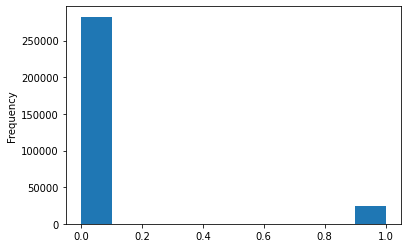

In [0]:
datasets["application_train"]['TARGET'].astype(int).plot.hist();

### Correlation with  the target column 

In [0]:
correlations = datasets["application_train"].corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(20))
print('\nMost Negative Correlations:\n', correlations.head(20))

Most Positive Correlations:
 OBS_30_CNT_SOCIAL_CIRCLE       0.009131
CNT_FAM_MEMBERS                0.009308
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
FLAG_WORK_PHONE                0.028524
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178918
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.15

### EDA

#### Applicants occupations

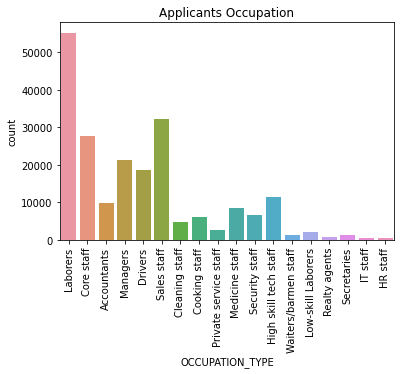

In [0]:
sns.countplot(x='OCCUPATION_TYPE', data=datasets["application_train"]);
plt.title('Applicants Occupation');
plt.xticks(rotation=90);

#### Contract Type or Type of Loan

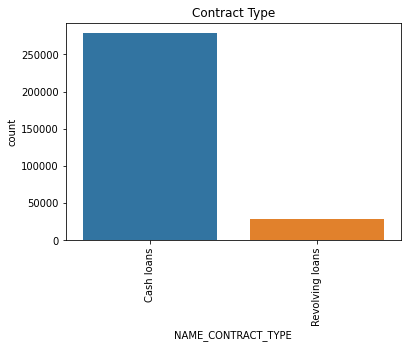

In [0]:
sns.countplot(x='NAME_CONTRACT_TYPE', data=datasets["application_train"]);
plt.title('Contract Type');
plt.xticks(rotation=90);

#### Owning a car vs real estate

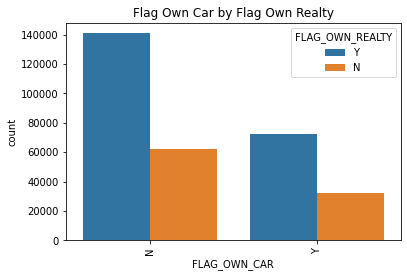

In [0]:
sns.countplot(x='FLAG_OWN_CAR',hue='FLAG_OWN_REALTY', data=application_train);
plt.title('Flag Own Car by Flag Own Realty');
plt.xticks(rotation=90);

#### Suite Type - Who accompanied client when applying for loan

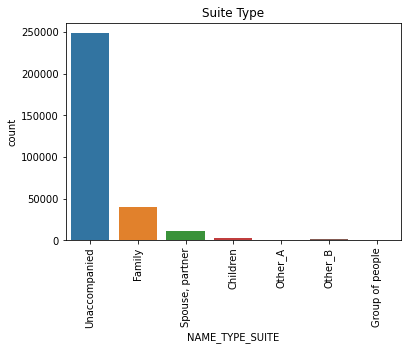

In [0]:
sns.countplot(x='NAME_TYPE_SUITE', data=datasets["application_train"]);
plt.title('Suite Type');
plt.xticks(rotation=90);
# can check by gender 
#another option is to check by the type of loan applied for

#### Loan Amount by Occupation Type

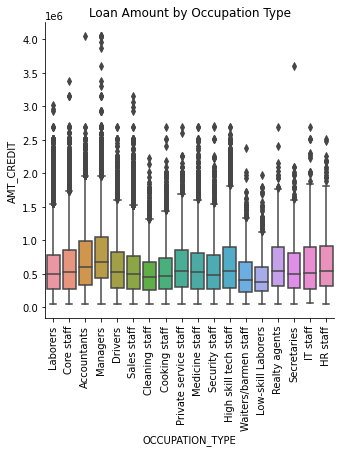

In [0]:
sns.catplot(x="OCCUPATION_TYPE", y="AMT_CREDIT", kind="box", data=application_train);
plt.title('Loan Amount by Occupation Type');
plt.xticks(rotation=90);

#### Loan Amount by Income Type

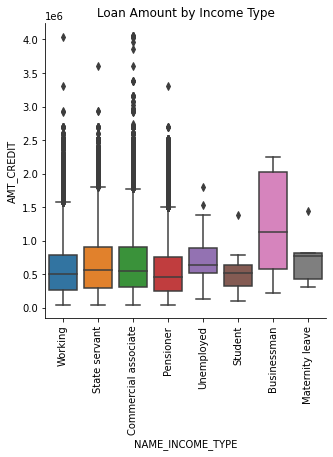

In [0]:
sns.catplot(x="NAME_INCOME_TYPE", y="AMT_CREDIT", kind="box", data=application_train);
plt.title('Loan Amount by Income Type');
plt.xticks(rotation=90);

### Feature Selection

Start with the categorical variables first i.e. (chi square) correlation between the categorical variables and the target

In [0]:
# Differentiate between categorical, binary and continuous variables

#cat_var= ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE",
#          "NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","OCCUPATION_TYPE","WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE","FONDKAPREMONT_MODE",
#         "HOUSETYPE_MODE","WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE"]
#bin_var

g = application_train.columns.to_series().groupby(application_train.dtypes).groups
cat_var=[]
bin_var=[]
cont_var=[]
   
for key, value in g.items():
    if key=='float64':
        cont_var=value
    elif key=='object':
        cat_var=value
    elif key=='int64':
        bin_var=value
        
cont_var=list(cont_var)#.tolist()
print(type(cont_var))
print(cont_var)
print(len(cont_var))

print('********************************')

cat_var=list(cat_var)#.tolist()
print(type(cat_var))
print(cat_var)
print(len(cat_var))

print('********************************')

bin_var=list(bin_var)#.tolist()
print(type(bin_var))
print(bin_var)
print(len(bin_var))

<class 'list'>
[]
0
********************************
<class 'list'>
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
16
********************************
<class 'list'>
[]
0


In [0]:
# fill all NaN cells with a string 'NaN'
for col in cat_var:
    application_train[col].fillna("NaN", inplace = True) 
#application_train[application_train.NAME_TYPE_SUITE=='NaN']

In [0]:
y = application_train['TARGET']
cat_train=pd.DataFrame()

for col in cat_var:
    dummy=pd.get_dummies(application_train[col],prefix=col)
    cat_train=pd.concat([cat_train,dummy],axis=1)
cat_train.head()
#print(feature_summary(cat_train))
# copied this code from : https://www.kaggle.com/rahullalu/home-credit-default-risk-eda
print(len(cat_train.columns))

146


In [0]:
chi2_selector_cat = SelectKBest(chi2, k=146)
X_kbest = chi2_selector_cat.fit_transform(cat_train, y)
df_chi_cat=pd.DataFrame(chi2_selector_cat.scores_,columns=['chi_score'])
df_chi_cat['columns']=cat_train.columns
df_chi_cat_s=df_chi_cat.sort_values(by='chi_score')
#display(df_chi_cat_s)
#print(df_chi_cat_s[df_chi_cat_s.chi_score<1])

In [0]:
cat_vars_to_drop=df_chi_cat_s[df_chi_cat_s.chi_score>=1]['columns']
cat_vars_to_drop

90       ORGANIZATION_TYPE_Industry: type 5
84      ORGANIZATION_TYPE_Industry: type 11
63      WEEKDAY_APPR_PROCESS_START_SATURDAY
22                 NAME_INCOME_TYPE_Student
49                 OCCUPATION_TYPE_IT staff
                       ...                 
24                 NAME_INCOME_TYPE_Working
125                   ORGANIZATION_TYPE_XNA
20               NAME_INCOME_TYPE_Pensioner
3                             CODE_GENDER_M
26     NAME_EDUCATION_TYPE_Higher education
Name: columns, Length: 113, dtype: object

In [0]:
dropCols = {}
dropCols['cat_cols'] = cat_vars_to_drop

In [0]:
Bin_vars_to_analyze_2 = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
                         'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                         'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
# fill all NaN cells with a string 'NaN'
for col in Bin_vars_to_analyze_2:
    application_train[col].fillna("NaN", inplace = True) 
#application_train[application_train.REG_CITY_NOT_LIVE_CITY=='NaN']


In [0]:
Bin_vars_to_analyze_2_train=pd.DataFrame()
for col in Bin_vars_to_analyze_2:
    dummy=pd.get_dummies(application_train[col],prefix=col)
    #print(dummy)
    Bin_vars_to_analyze_2_train=pd.concat([Bin_vars_to_analyze_2_train,dummy],axis=1)
Bin_vars_to_analyze_2_train
#print(feature_summary(cat_train))
# copied this code from : https://www.kaggle.com/rahullalu/home-credit-default-risk-eda
print(len(Bin_vars_to_analyze_2_train.columns))

42


In [0]:
chi2_selector_bin = SelectKBest(chi2, k=42)
X_kbest = chi2_selector_bin.fit_transform(Bin_vars_to_analyze_2_train, y)
df_chi_bin=pd.DataFrame(chi2_selector_bin.scores_,columns=['chi_score'])
df_chi_bin['columns']=Bin_vars_to_analyze_2_train.columns
df_chi_bin_s=df_chi_bin.sort_values(by='chi_score')
#display(df_chi_bin_s)
print(df_chi_bin_s[df_chi_bin_s.chi_score<1])

    chi_score                        columns
17   0.000108     HOUR_APPR_PROCESS_START_11
7    0.000515      HOUR_APPR_PROCESS_START_1
19   0.088800     HOUR_APPR_PROCESS_START_13
34   0.099392  LIVE_REGION_NOT_WORK_REGION_0
10   0.117927      HOUR_APPR_PROCESS_START_4
16   0.132406     HOUR_APPR_PROCESS_START_10
30   0.144792   REG_REGION_NOT_LIVE_REGION_0
15   0.649188      HOUR_APPR_PROCESS_START_9
9    0.650137      HOUR_APPR_PROCESS_START_3
28   0.750647     HOUR_APPR_PROCESS_START_22
32   0.752344   REG_REGION_NOT_WORK_REGION_0
29   0.938811     HOUR_APPR_PROCESS_START_23


In [0]:
bin_columns_to_drop = df_chi_bin_s[df_chi_bin_s.chi_score>=1]['columns']
bin_columns_to_drop

20       HOUR_APPR_PROCESS_START_14
8         HOUR_APPR_PROCESS_START_2
18       HOUR_APPR_PROCESS_START_12
26       HOUR_APPR_PROCESS_START_20
27       HOUR_APPR_PROCESS_START_21
35    LIVE_REGION_NOT_WORK_REGION_1
6         HOUR_APPR_PROCESS_START_0
4     REGION_RATING_CLIENT_W_CITY_2
25       HOUR_APPR_PROCESS_START_19
21       HOUR_APPR_PROCESS_START_15
31     REG_REGION_NOT_LIVE_REGION_1
22       HOUR_APPR_PROCESS_START_16
1            REGION_RATING_CLIENT_2
24       HOUR_APPR_PROCESS_START_18
33     REG_REGION_NOT_WORK_REGION_1
14        HOUR_APPR_PROCESS_START_8
11        HOUR_APPR_PROCESS_START_5
36         REG_CITY_NOT_LIVE_CITY_0
13        HOUR_APPR_PROCESS_START_7
23       HOUR_APPR_PROCESS_START_17
40        LIVE_CITY_NOT_WORK_CITY_0
12        HOUR_APPR_PROCESS_START_6
38         REG_CITY_NOT_WORK_CITY_0
41        LIVE_CITY_NOT_WORK_CITY_1
0            REGION_RATING_CLIENT_1
3     REGION_RATING_CLIENT_W_CITY_1
37         REG_CITY_NOT_LIVE_CITY_1
2            REGION_RATING_C

In [0]:
dropCols['bin_cols'] = bin_columns_to_drop

A number of documents are required to be submitted by a client when applying for a loan. The dataset description provided outlines 20 documents. 
Therefore, check correlation between documents and the target.

In [0]:
DOCUMENTS=["FLAG_DOCUMENT_2","FLAG_DOCUMENT_3","FLAG_DOCUMENT_4","FLAG_DOCUMENT_5","FLAG_DOCUMENT_6","FLAG_DOCUMENT_7","FLAG_DOCUMENT_8","FLAG_DOCUMENT_9",
          "FLAG_DOCUMENT_10","FLAG_DOCUMENT_11","FLAG_DOCUMENT_12","FLAG_DOCUMENT_13","FLAG_DOCUMENT_14","FLAG_DOCUMENT_15","FLAG_DOCUMENT_16","FLAG_DOCUMENT_17",
          "FLAG_DOCUMENT_18","FLAG_DOCUMENT_19","FLAG_DOCUMENT_20","FLAG_DOCUMENT_21"]

documents_df = application_train.loc[:, DOCUMENTS]


In [0]:
# check which documents are correlated with the target
chi2_selector_doc = SelectKBest(chi2)
X_kbest = chi2_selector_doc.fit_transform(documents_df, y)
df_chi_doc=pd.DataFrame(chi2_selector_doc.scores_,columns=['chi_score'])
df_chi_doc['columns']=documents_df.columns
df_chi_doc_s=df_chi_doc.sort_values(by='chi_score')
#display(df_chi_doc_s)
print(df_chi_doc_s[df_chi_doc_s.chi_score<1])

    chi_score           columns
18   0.014260  FLAG_DOCUMENT_20
3    0.030200   FLAG_DOCUMENT_5
10   0.175637  FLAG_DOCUMENT_12
17   0.566361  FLAG_DOCUMENT_19
8    0.614728  FLAG_DOCUMENT_10
5    0.709873   FLAG_DOCUMENT_7


In [0]:
doc_vars_to_drop=df_chi_doc_s[df_chi_doc_s.chi_score>=1]['columns']
doc_vars_to_drop

2      FLAG_DOCUMENT_4
15    FLAG_DOCUMENT_17
19    FLAG_DOCUMENT_21
9     FLAG_DOCUMENT_11
7      FLAG_DOCUMENT_9
0      FLAG_DOCUMENT_2
13    FLAG_DOCUMENT_15
6      FLAG_DOCUMENT_8
16    FLAG_DOCUMENT_18
12    FLAG_DOCUMENT_14
14    FLAG_DOCUMENT_16
11    FLAG_DOCUMENT_13
1      FLAG_DOCUMENT_3
4      FLAG_DOCUMENT_6
Name: columns, dtype: object

In [0]:
dropCols['doc_vars'] = doc_vars_to_drop

In [0]:
Bin_vars_to_analyze =['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']

Bin_vars_df = application_train.loc[:, Bin_vars_to_analyze]


In [0]:
# check which COLUMNS FROM Bin_vars_to_analyze  are correlated with the target
chi2_selector_flags = SelectKBest(chi2,k=6)
chi2_selector_flags
X_kbest = chi2_selector_flags.fit_transform(Bin_vars_df, y)
df_chi_flags=pd.DataFrame(chi2_selector_flags.scores_,columns=['chi_score'])
df_chi_flags['columns']=Bin_vars_df.columns
df_chi_flags_s=df_chi_flags.sort_values(by='chi_score')
#display(df_chi_flags_s)
print(df_chi_flags_s[df_chi_flags_s.chi_score<1])

      chi_score           columns
0  2.855786e-07        FLAG_MOBIL
3  7.863447e-05  FLAG_CONT_MOBILE
5  8.968679e-01        FLAG_EMAIL


In [0]:
flag_vars_to_drop=df_chi_flags_s[df_chi_flags_s.chi_score>=1]['columns']
flag_vars_to_drop

1     FLAG_EMP_PHONE
4         FLAG_PHONE
2    FLAG_WORK_PHONE
Name: columns, dtype: object

In [0]:
dropCols['flag_vars'] = flag_vars_to_drop

In [0]:
#From the above analysis, the following columns are selected:
'''
     chi_score                                   columns
92    0.002709        ORGANIZATION_TYPE_Industry: type 7
68    0.004238             ORGANIZATION_TYPE_Advertising
97    0.017109          ORGANIZATION_TYPE_Legal Services
36    0.029895         NAME_HOUSING_TYPE_Co-op apartment
71    0.034580  ORGANIZATION_TYPE_Business Entity Type 1
56    0.047517             OCCUPATION_TYPE_Realty agents
65    0.051080       WEEKDAY_APPR_PROCESS_START_THURSDAY
11    0.062650           NAME_TYPE_SUITE_Group of people
81    0.065637                 ORGANIZATION_TYPE_Housing
139   0.120730                 WALLSMATERIAL_MODE_Others
91    0.130537        ORGANIZATION_TYPE_Industry: type 6
112   0.155514                 ORGANIZATION_TYPE_Telecom
34    0.175637                NAME_FAMILY_STATUS_Unknown
121   0.214727       ORGANIZATION_TYPE_Transport: type 2
117   0.251180           ORGANIZATION_TYPE_Trade: type 5
134   0.295641             HOUSETYPE_MODE_terraced house
113   0.327077           ORGANIZATION_TYPE_Trade: type 1
4     0.351273                           CODE_GENDER_XNA
61    0.371889         WEEKDAY_APPR_PROCESS_START_FRIDAY
103   0.386722                  ORGANIZATION_TYPE_Postal
32    0.392307              NAME_FAMILY_STATUS_Separated
83    0.400292       ORGANIZATION_TYPE_Industry: type 10
64    0.451054         WEEKDAY_APPR_PROCESS_START_SUNDAY
87    0.464595        ORGANIZATION_TYPE_Industry: type 2
100   0.493985                  ORGANIZATION_TYPE_Mobile
67    0.535490      WEEKDAY_APPR_PROCESS_START_WEDNESDAY
105   0.549597                ORGANIZATION_TYPE_Religion
13    0.576872                   NAME_TYPE_SUITE_Other_A
15    0.620773           NAME_TYPE_SUITE_Spouse, partner
93    0.633842        ORGANIZATION_TYPE_Industry: type 8
78    0.652687               ORGANIZATION_TYPE_Emergency
17    0.878183              NAME_INCOME_TYPE_Businessman
136   0.895626                  WALLSMATERIAL_MODE_Mixed

    chi_score                        columns
17   0.000108     HOUR_APPR_PROCESS_START_11
7    0.000515      HOUR_APPR_PROCESS_START_1
19   0.088800     HOUR_APPR_PROCESS_START_13
34   0.099392  LIVE_REGION_NOT_WORK_REGION_0
10   0.117927      HOUR_APPR_PROCESS_START_4
16   0.132406     HOUR_APPR_PROCESS_START_10
30   0.144792   REG_REGION_NOT_LIVE_REGION_0
15   0.649188      HOUR_APPR_PROCESS_START_9
9    0.650137      HOUR_APPR_PROCESS_START_3
28   0.750647     HOUR_APPR_PROCESS_START_22
32   0.752344   REG_REGION_NOT_WORK_REGION_0
29   0.938811     HOUR_APPR_PROCESS_START_23

    chi_score           columns
18   0.014260  FLAG_DOCUMENT_20
3    0.030200   FLAG_DOCUMENT_5
10   0.175637  FLAG_DOCUMENT_12
17   0.566361  FLAG_DOCUMENT_19
8    0.614728  FLAG_DOCUMENT_10
5    0.709873   FLAG_DOCUMENT_7

      chi_score           columns
0  2.855786e-07        FLAG_MOBIL
3  7.863447e-05  FLAG_CONT_MOBILE
5  8.968679e-01        FLAG_EMAIL

'''
# Additionally, we will continue to use all continuous variables since PCA analysis will be conducted after merging all 
# datasets

'\n     chi_score                                   columns\n92    0.002709        ORGANIZATION_TYPE_Industry: type 7\n68    0.004238             ORGANIZATION_TYPE_Advertising\n97    0.017109          ORGANIZATION_TYPE_Legal Services\n36    0.029895         NAME_HOUSING_TYPE_Co-op apartment\n71    0.034580  ORGANIZATION_TYPE_Business Entity Type 1\n56    0.047517             OCCUPATION_TYPE_Realty agents\n65    0.051080       WEEKDAY_APPR_PROCESS_START_THURSDAY\n11    0.062650           NAME_TYPE_SUITE_Group of people\n81    0.065637                 ORGANIZATION_TYPE_Housing\n139   0.120730                 WALLSMATERIAL_MODE_Others\n91    0.130537        ORGANIZATION_TYPE_Industry: type 6\n112   0.155514                 ORGANIZATION_TYPE_Telecom\n34    0.175637                NAME_FAMILY_STATUS_Unknown\n121   0.214727       ORGANIZATION_TYPE_Transport: type 2\n117   0.251180           ORGANIZATION_TYPE_Trade: type 5\n134   0.295641             HOUSETYPE_MODE_terraced house\n113   0.327

In [0]:
# In Application_Train, convert the columns in cat_var to catgorical variables
for col in cat_var:
    application_train[col] = pd.Categorical(application_train[col])
    dfDummies = pd.get_dummies(application_train[col], prefix = col)
    application_train = pd.concat([application_train, dfDummies], axis=1)
#application_train

# Now drop the actual columns (i.e. cat_var)
application_train=application_train.drop(cat_var,axis=1)
#application_train
# Lets try dropping the categorical variables we dont need i.e. cat_vars_to_drop
for col in cat_vars_to_drop:
    application_train=application_train.drop(col,axis=1)
application_train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_XNA,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_Co-op apartment,OCCUPATION_TYPE_Realty agents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Transport: type 2,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Others
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,0.014900,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,

In [0]:
# In Application_Train, convert the columns in Bin_vars_to_analyze_2 to catgorical variables
for col in Bin_vars_to_analyze_2:
    application_train[col] = pd.Categorical(application_train[col])
    dfDummies = pd.get_dummies(application_train[col], prefix = col)
    application_train = pd.concat([application_train, dfDummies], axis=1)
#application_train

# Now drop the actual columns (i.e. cat_var)
application_train=application_train.drop(Bin_vars_to_analyze_2,axis=1)
#application_train
# Lets try dropping the categorical variables we dont need i.e. cat_vars_to_drop
for col in bin_columns_to_drop:
    application_train=application_train.drop(col,axis=1)
application_train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_XNA,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_Co-op apartment,OCCUPATION_TYPE_Realty agents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Transport: type 2,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Others,HOUR_APPR_PROCESS_START_1,HOUR_APPR_PROCESS_START_3,HOUR_APPR_PROCESS_START_4,HOUR_APPR_PROCESS_START_9,HOUR_APPR_PROCESS_START_10,HOUR_APPR_PROCESS_START_11,HOUR_APPR_PROCESS_START_13,HOUR_APPR_PROCESS_START_22,HOUR_APPR_PROCESS_START_23,REG_REGION_NOT_LIVE_REGION_0,REG_REGION_NOT_WORK_REGION_0,LIVE_REGION_NOT_WORK_REGION_0
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,0.014900,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.9848

In [0]:
# Drop columns from doc_vars_to_drop
for col in doc_vars_to_drop:
    application_train=application_train.drop(col,axis=1)
application_train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_5,FLAG_DOCUMENT_7,FLAG_DOCUMENT_10,FLAG_DOCUMENT_12,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_XNA,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_Co-op apartment,OCCUPATION_TYPE_Realty agents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Transport: type 2,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Others,HOUR_APPR_PROCESS_START_1,HOUR_APPR_PROCESS_START_3,HOUR_APPR_PROCESS_START_4,HOUR_APPR_PROCESS_START_9,HOUR_APPR_PROCESS_START_10,HOUR_APPR_PROCESS_START_11,HOUR_APPR_PROCESS_START_13,HOUR_APPR_PROCESS_START_22,HOUR_APPR_PROCESS_START_23,REG_REGION_NOT_LIVE_REGION_0,REG_REGION_NOT_WORK_REGION_0,LIVE_REGION_NOT_WORK_REGION_0
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,0.014900,2.0,2.0,2.0,2.0,-1134.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.000000,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,0.071411,1.0,0.0,1.0,0.0,-828.0,0,0,0

In [0]:
# Drop columns from flag_vars_to_drop
for col in flag_vars_to_drop:
    application_train=application_train.drop(col,axis=1)
application_train

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_CONT_MOBILE,FLAG_EMAIL,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_5,FLAG_DOCUMENT_7,FLAG_DOCUMENT_10,FLAG_DOCUMENT_12,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_XNA,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_Co-op apartment,OCCUPATION_TYPE_Realty agents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Transport: type 2,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Others,HOUR_APPR_PROCESS_START_1,HOUR_APPR_PROCESS_START_3,HOUR_APPR_PROCESS_START_4,HOUR_APPR_PROCESS_START_9,HOUR_APPR_PROCESS_START_10,HOUR_APPR_PROCESS_START_11,HOUR_APPR_PROCESS_START_13,HOUR_APPR_PROCESS_START_22,HOUR_APPR_PROCESS_START_23,REG_REGION_NOT_LIVE_REGION_0,REG_REGION_NOT_WORK_REGION_0,LIVE_REGION_NOT_WORK_REGION_0
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1.0,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,0.014900,2.0,2.0,2.0,2.0,-1134.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,2.0,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.000000,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,0.071411,1.0,0.0,1.0,0.0,-828.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0

Random check to see if any improvement in performance:

In [0]:
def pct(x):
    return round(100*x,3)

In [0]:
'''
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
'''

"\n# Create a class to select numerical or categorical columns \n# since Scikit-Learn doesn't handle DataFrames yet\nclass DataFrameSelector(BaseEstimator, TransformerMixin):\n    def __init__(self, attribute_names):\n        self.attribute_names = attribute_names\n    def fit(self, X, y=None):\n        return self\n    def transform(self, X):\n        return X[self.attribute_names].values\n"

In [0]:
selected_columns=list(application_train.columns)
selected_columns.remove('SK_ID_CURR')
selected_columns.remove('TARGET')

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(application_train[selected_columns], application_train['TARGET'], test_size=0.25, random_state=0)

In [0]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(cont_var)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

In [0]:
'''%%time 
np.random.seed(42)
full_pipeline = Pipeline([
        ("preparation", num_pipeline),
        ("linear", LogisticRegression())
    ])
model = full_pipeline.fit(x_train, y_train)'''

'%%time \nnp.random.seed(42)\nfull_pipeline = Pipeline([\n        ("preparation", num_pipeline),\n        ("linear", LogisticRegression())\n    ])\nmodel = full_pipeline.fit(x_train, y_train)'

In [0]:
'''from sklearn.metrics import accuracy_score
np.round(accuracy_score(y_test, model.predict(x_test)), 3)'''

'from sklearn.metrics import accuracy_score\nnp.round(accuracy_score(y_test, model.predict(x_test)), 3)'

In [0]:
# Continuous variables

# convert the birth_days to years
application_train['YEARS_BIRTH']=(application_train['DAYS_BIRTH']/-365)
application_train['YEARS_BIRTH']=application_train['DAYS_BIRTH'].astype(int)
application_train

# convert the days_employed to years
application_train['YEARS_EMPLOYED']=(application_train['DAYS_EMPLOYED']/-365)
application_train['YEARS_EMPLOYED']=application_train['DAYS_EMPLOYED'].astype(int)
application_train

# convert the DAYS_REGISTRATION to years
application_train['YEARS_REGISTRATION']=(application_train['DAYS_REGISTRATION']/-365)
application_train['YEARS_REGISTRATION']=application_train['DAYS_REGISTRATION'].astype(int)
application_train

# convert the DAYS_ID_PUBLISH to years
application_train['YEARS_ID_PUBLISH']=(application_train['DAYS_ID_PUBLISH']/-365)
application_train['YEARS_ID_PUBLISH']=application_train['DAYS_ID_PUBLISH'].astype(int)
application_train

cont_vars_to_drop = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']
for col in cont_vars_to_drop:
    application_train=application_train.drop(col,axis=1)
                    

In [0]:
dropCols['cont_vars'] = cont_vars_to_drop

In [0]:
dictlist = []
for key, value in dropCols.items():
    for val in value:
        temp = [key,val]
        dictlist.append(temp)
#dfDropCols = pd.DataFrame(dictlist,columns=['dropCat','dropCol'])
#dfDropCols.to_csv("/content/drive/My Drive/HCDR/dropCols.csv", index=False)

## Bureau

### Summary

In [0]:
bureaudf = datasets["bureau"]

In [0]:
bureaudf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int32  
 1   SK_ID_BUREAU            int32  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int16  
 5   CREDIT_DAY_OVERDUE      int16  
 6   DAYS_CREDIT_ENDDATE     float16
 7   DAYS_ENDDATE_FACT       float16
 8   AMT_CREDIT_MAX_OVERDUE  float32
 9   CNT_CREDIT_PROLONG      int8   
 10  AMT_CREDIT_SUM          float32
 11  AMT_CREDIT_SUM_DEBT     float32
 12  AMT_CREDIT_SUM_LIMIT    float32
 13  AMT_CREDIT_SUM_OVERDUE  float32
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int32  
 16  AMT_ANNUITY             float32
dtypes: float16(2), float32(6), int16(2), int32(3), int8(1), object(3)
memory usage: 112.9+ MB


In [0]:
bureaudf.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [0]:
day_convert(bureaudf)
bureaudf.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,497,0,153.0,153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,131,NaN
1,215354,5714463,Active,currency 1,208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,20,NaN
2,215354,5714464,Active,currency 1,203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,16,NaN
3,215354,5714465,Active,currency 1,203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,16,NaN
4,215354,5714466,Active,currency 1,629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,21,NaN


In [0]:
bureaudf.describe(include='all')

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1610875.0,1082775.0,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,1.142108e+03,8.181666e-01,NaN,NaN,3.825358e+03,6.410406e-03,3.545773e+05,1.370818e+05,6.229781e+03,3.791263e+01,NaN,5.937491e+02,1.571327e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,NaN,NaN,2.059873e+05,9.622391e-02,1.150277e+06,6.790749e+05,4.489666e+04,5.937519e+03,NaN,7.207467e+02,3.256556e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,4.740000e+02,0.000000e+00,381.0,425.0,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,3.300000e+01,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,9.870000e+02,0.000000e+00,862.0,897.0,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,1.666000e+03,0.000000e+00,1504.0,1489.0,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,9.080000e+02,1.350000e+04


In [0]:
bureau = bureaudf.groupby(['SK_ID_CURR']).agg(['mean', 'count', 'std', 'sum', 'min', 'max'])
bureau.columns = [ '_'.join(str(i) for i in col) for col in bureau.columns]
bureau.reset_index(inplace=True)

In [0]:
bureau

,SK_ID_CURR,SK_ID_BUREAU_mean,SK_ID_BUREAU_count,SK_ID_BUREAU_std,SK_ID_BUREAU_sum,SK_ID_BUREAU_min,SK_ID_BUREAU_max,DAYS_CREDIT_mean,DAYS_CREDIT_count,DAYS_CREDIT_std,DAYS_CREDIT_sum,DAYS_CREDIT_min,DAYS_CREDIT_max,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_count,CREDIT_DAY_OVERDUE_std,CREDIT_DAY_OVERDUE_sum,CREDIT_DAY_OVERDUE_min,CREDIT_DAY_OVERDUE_max,DAYS_CREDIT_ENDDATE_mean,DAYS_CREDIT_ENDDATE_count,DAYS_CREDIT_ENDDATE_std,DAYS_CREDIT_ENDDATE_sum,DAYS_CREDIT_ENDDATE_min,DAYS_CREDIT_ENDDATE_max,DAYS_ENDDATE_FACT_mean,DAYS_ENDDATE_FACT_count,DAYS_ENDDATE_FACT_std,DAYS_ENDDATE_FACT_sum,DAYS_ENDDATE_FACT_min,DAYS_ENDDATE_FACT_max,AMT_CREDIT_MAX_OVERDUE_mean,AMT_CREDIT_MAX_OVERDUE_count,AMT_CREDIT_MAX_OVERDUE_std,AMT_CREDIT_MAX_OVERDUE_sum,AMT_CREDIT_MAX_OVERDUE_min,AMT_CREDIT_MAX_OVERDUE_max,CNT_CREDIT_PROLONG_mean,CNT_CREDIT_PROLONG_count,CNT_CREDIT_PROLONG_std,CNT_CREDIT_PROLONG_sum,CNT_CREDIT_PROLONG_min,CNT_CREDIT_PROLONG_max,AMT_CREDIT_SUM_mean,AMT_CREDIT_SUM_count,AMT_CREDIT_SUM_std,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_min,AMT_CREDIT_SUM_max,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_DEBT_count,AMT_CREDIT_SUM_DEBT_std,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_DEBT_max,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_LIMIT_count,AMT_CREDIT_SUM_LIMIT_std,AMT_CREDIT_SUM_LIMIT_sum,AMT_CREDIT_SUM_LIMIT_min,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_count,AMT_CREDIT_SUM_OVERDUE_std,AMT_CREDIT_SUM_OVERDUE_sum,AMT_CREDIT_SUM_OVERDUE_min,AMT_CREDIT_SUM_OVERDUE_max,DAYS_CREDIT_UPDATE_mean,DAYS_CREDIT_UPDATE_count,DAYS_CREDIT_UPDATE_std,DAYS_CREDIT_UPDATE_sum,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_UPDATE_max,AMT_ANNUITY_mean,AMT_ANNUITY_count,AMT_ANNUITY_std,AMT_ANNUITY_sum,AMT_ANNUITY_min,AMT_ANNUITY_max
0,100001,5896633.000,7,2.160247,41276431,5896630,5896636,735.000000,7,489.942514,5145.0,49,1572,0.0,7,0.0,0,0,0,800.5,7,inf,5604.0,179.0,1778.0,825.5,4,inf,3302.0,544.0,1328.0,NaN,0,NaN,0.000000,NaN,NaN,0.000000,7,0.000000,0,0,0,2.076236e+05,7,122544.546875,1.453365e+06,85500.0,3.780000e+05,85240.929688,7,137485.625000,596686.5,0.0,373239.0,0.000000,6,0.000000,0.000000,0.0,0.000000,0.0,7,0.0,0.0,0.0,0.0,93.142857,7,77.204120,652,6,155,3545.357178,7,4800.607422,24817.50000,0.000000,10822.5
1,100002,6153272.125,8,15935.004993,49226177,6113835,6158909,874.000000,8,431.451040,6992.0,103,1437,0.0,8,0.0,0,0,0,658.0,6,inf,3948.0,62.0,1072.0,697.5,6,inf,4184.0,36.0,1185.0,1681.029053,5,2363.246826,8405.144531,0.0,5043.64502,0.000000,8,0.000000,0,0,0,1.081319e+05,8,146075.562500,8.650556e+05,0.0,4.500000e+05,49156.199219,5,109916.601562,245781.0,0.0,245781.0,7997.141113,4,15994.282227,31988.564453,0.0,31988.564453,0.0,8,0.0,0.0,0.0,0.0,499.875000,8,518.522472,3999,7,1185,0.000000,7,0.000000,0.00000,0.000000,0.0
2,100003,5885878.500,4,1.290994,23543514,5885877,5885880,1400.750000,4,909.826128,5603.0,606,2586,0.0,4,0.0,0,0,0,1152.0,4,inf,4608.0,420.0,2434.0,1098.0,3,inf,3292.0,540.0,2132.0,0.000000,4,0.000000,0.000000,0.0,0.00000,0.000000,4,0.000000,0,0,0,2.543501e+05,4,372269.468750,1.017400e+06,22248.0,8.100000e+05,0.000000,4,0.000000,0.0,0.0,0.0,202500.000000,4,405000.000000,810000.000000,0.0,810000.000000,0.0,4,0.0,0.0,0.0,0.0,816.000000,4,908.053963,3264,43,2131,NaN,0,NaN,0.00000,NaN,NaN
3,100004,6829133.500,2,0.707107,13658267,6829133,6829134,867.000000,2,649.124025,1734.0,408,1326,0.0,2,0.0,0,0,0,488.5,2,150.625,977.0,382.0,595.0,532.5,2,212.875,1065.0,382.0,683.0,0.000000,1,NaN,0.000000,0.0,0.00000,0.000000,2,0.000000,0,0,0,9.451890e+04,2,26.726427,1.890378e+05,94500.0,9.453780e+04,0.000000,2,0.000000,0.0,0.0,0.0,0.000000,2,0.000000,0.000000,0.0,0.000000,0.0,2,0.0,0.0,0.0,0.0,532.000000,2,212.132034,1064,382,682,NaN,0,NaN,0.00000,NaN,NaN
4,100005,6735201.000,3,1.000000,20205603,6735200,6735202,190.666667,3,162.297053,572.0,62,373,0.0,3,0.0,0,0,0,524.5,3,inf,1574.0,122.0,1324.0,123.0,1,NaN,123.0,123.0,123.0,0.000000,1,NaN,0.000000,0.0,0.00000,0.000000,3,0.000000,0,0,0,2.190420e+05,3,303238.437500,6

In [0]:
credit= bureaudf.groupby(['SK_ID_CURR']).transform('count')

In [0]:
credit

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,11,11,11,11,11,10,5,3,11,11,6,3,11,11,11,0
1,11,11,11,11,11,10,5,3,11,11,6,3,11,11,11,0
2,11,11,11,11,11,10,5,3,11,11,6,3,11,11,11,0
3,11,11,11,11,11,10,5,3,11,11,6,3,11,11,11,0
4,11,11,11,11,11,10,5,3,11,11,6,3,11,11,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,3,3,3,3,3,3,0,3,3,3,3,3,3,3,3,0
1716424,11,11,11,11,11,11,5,7,11,11,9,9,11,11,11,0
1716425,11,11,11,11,11,11,5,7,11,11,9,9,11,11,11,0
1716426,31,31,31,31,31,19,23,4,31,31,31,10,31,31,31,0


### Principle Component Analysis

In [0]:
other = datasets["application_train"]
other1= other[['SK_ID_CURR', 'TARGET']]
bureautrain = bureau.set_index('SK_ID_CURR').join(other1.set_index('SK_ID_CURR'))

In [0]:
correlations = bureautrain.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 AMT_CREDIT_MAX_OVERDUE_count    0.008226
AMT_CREDIT_SUM_OVERDUE_max      0.010614
AMT_CREDIT_SUM_OVERDUE_std      0.011157
DAYS_CREDIT_ENDDATE_min         0.012364
AMT_CREDIT_SUM_OVERDUE_sum      0.013335
AMT_ANNUITY_count               0.015387
DAYS_CREDIT_ENDDATE_sum         0.016715
DAYS_CREDIT_ENDDATE_mean        0.028485
DAYS_CREDIT_ENDDATE_max         0.031617
TARGET                          1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 DAYS_CREDIT_mean          -0.089729
DAYS_CREDIT_max           -0.075248
DAYS_CREDIT_UPDATE_mean   -0.068928
DAYS_ENDDATE_FACT_max     -0.055886
DAYS_ENDDATE_FACT_mean    -0.053199
DAYS_CREDIT_std           -0.050064
DAYS_CREDIT_min           -0.049782
DAYS_ENDDATE_FACT_sum     -0.048862
DAYS_CREDIT_UPDATE_max    -0.042864
DAYS_CREDIT_sum           -0.042000
Name: TARGET, dtype: float64


## bureau_balance

### Summary

In [0]:
bureaubaldf = datasets["bureau_balance"]

In [0]:
bureaubaldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int32 
 1   MONTHS_BALANCE  int8  
 2   STATUS          object
dtypes: int32(1), int8(1), object(1)
memory usage: 338.5+ MB


In [0]:
bureaubaldf.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [0]:
bureaubaldf.describe(include='all')

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
count,2.729992e+07,2.729992e+07,27299925
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,13646993
mean,6.036297e+06,-3.074169e+01,NaN
std,4.923489e+05,2.386451e+01,NaN
min,5.001709e+06,-9.600000e+01,NaN
25%,5.730933e+06,-4.600000e+01,NaN
50%,6.070821e+06,-2.500000e+01,NaN
75%,6.431951e+06,-1.100000e+01,NaN


## Previous Applications Dataset

### Summary

* __SK_ID_PREV__ ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit) 
* __SK_ID_CURR__ ID of loan in our sample
* __NAME_CONTRACT_TYPE__ Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application
* __AMT_ANNUITY__ Annuity of previous application
* __AMT_APPLICATION__ For how much credit did client ask on the previous application
* __AMT_CREDIT__ Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT
* __AMT_DOWN_PAYMENT__ Down payment on the previous application
* __AMT_GOODS_PRICE__ Goods price of good that client asked for (if applicable) on the previous application
* __WEEKDAY_APPR_PROCESS_START__ On which day of the week did the client apply for previous application
* __HOUR_APPR_PROCESS_START__ Approximately at what day hour did the client apply for the previous application
* __FLAG_LAST_APPL_PER_CONTRACT__ Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract
* __NFLAG_LAST_APPL_IN_DAY__ Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice
* __NFLAG_MICRO_CASH__ Flag Micro finance loan
* __RATE_DOWN_PAYMENT__ Down payment rate normalized on previous credit
* __RATE_INTEREST_PRIMARY__ Interest rate normalized on previous credit
* __RATE_INTEREST_PRIVILEGED__ Interest rate normalized on previous credit
* __NAME_CASH_LOAN_PURPOSE__ Purpose of the cash loan
* __NAME_CONTRACT_STATUS__ Contract status (approved, cancelled, ...) of previous application
* __DAYS_DECISION__ Relative to current application when was the decision about previous application made
* __NAME_PAYMENT_TYPE__ Payment method that client chose to pay for the previous application
* __CODE_REJECT_REASON__ Why was the previous application rejected
* __NAME_TYPE_SUITE__ Who accompanied client when applying for the previous application
* __NAME_CLIENT_TYPE__ Was the client old or new client when applying for the previous application
* __NAME_GOODS_CATEGORY__ What kind of goods did the client apply for in the previous application
* __NAME_PORTFOLIO__ Was the previous application for CASH, POS, CAR, …
* __NAME_PRODUCT_TYPE__ Was the previous application x-sell o walk-in
* __CHANNEL_TYPE__ Through which channel we acquired the client on the previous application
* __SELLERPLACE_AREA__ Selling area of seller place of the previous application
* __NAME_SELLER_INDUSTRY__ The industry of the seller
* __CNT_PAYMENT__ Term of previous credit at application of the previous application
* __NAME_YIELD_GROUP__ Grouped interest rate into small medium and high of the previous application
* __PRODUCT_COMBINATION__ Detailed product combination of the previous application
* __DAYS_FIRST_DRAWING__ Relative to application date of current application when was the first disbursement of the previous application
* __DAYS_FIRST_DUE__ Relative to application date of current application when was the first due supposed to be of the previous application
* __DAYS_LAST_DUE_1ST_VERSION__ Relative to application date of current application when was the first due of the previous application
* __DAYS_LAST_DUE__ Relative to application date of current application when was the last due date of the previous application
* __DAYS_TERMINATION__ Relative to application date of current application when was the expected termination of the previous application
* __NFLAG_INSURED_ON_APPROVAL__ Did the client requested insurance during the previous application

In [22]:
appsDF = datasets["previous_application"]
appsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int32
SK_ID_CURR                     1670214 non-null int32
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float32
AMT_APPLICATION                1670214 non-null float32
AMT_CREDIT                     1670213 non-null float32
AMT_DOWN_PAYMENT               774370 non-null float32
AMT_GOODS_PRICE                1284699 non-null float32
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int8
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int8
RATE_DOWN_PAYMENT              774370 non-null float16
RATE_INTEREST_PRIMARY          5951 non-null float16
RATE_INTEREST_PRIVILEGED       5951 non-null float16
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRACT

In [0]:
appsDF.isna().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

In [0]:
print("There are ",appsDF.shape[0]," previous applications which are from ", len(np.intersect1d(appsDF["SK_ID_CURR"], datasets["application_test"]["SK_ID_CURR"])), "unique applicants")

There are  1670214  previous applications which are from  47800 unique applicants


In [0]:
apps_all = appsDF['SK_ID_CURR'].nunique()
apps_5plus = appsDF['SK_ID_CURR'].value_counts()>=5
apps_40plus = appsDF['SK_ID_CURR'].value_counts()>=40
print('Percentage with 5 or more previous apps:', np.round(100.*(sum(apps_5plus)/apps_all),5))
print('Percentage with 40 or more previous apps:', np.round(100.*(sum(apps_40plus)/apps_all),5))

Percentage with 5 or more previous apps: 41.76895
Percentage with 40 or more previous apps: 0.03453


In [0]:
appsDF.describe(include='all')

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1670214,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1670214,1.670214e+06,1670214,1.670214e+06,774370.000000,5951.000000,5951.000000,1670214,1670214,1.670214e+06,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1.670214e+06,1670214,1297984.0,1670214,1669868,997149.000000,997149.000000,997149.000000,997149.000000,997149.00000,997149.0
unique,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,7,NaN,2,NaN,NaN,NaN,NaN,25,4,NaN,4,9,7,4,28,5,3,8,NaN,11,NaN,5,17,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,NaN,NaN,NaN,NaN,NaN,TUESDAY,NaN,Y,NaN,NaN,NaN,NaN,XAP,Approved,NaN,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,NaN,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,747553,NaN,NaN,NaN,NaN,NaN,255118,NaN,1661739,NaN,NaN,NaN,NaN,922661,1036781,NaN,1033552,1353093,508970,1231261,950809,691011,1063666,719968,NaN,855720,NaN,517215,285990,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.923089e+06,2.783572e+05,NaN,1.594889e+04,1.749806e+05,1.960131e+05,6.699080e+03,2.275182e+05,NaN,1.248418e+01,NaN,9.964675e-01,0.079651,0.188599,0.774902,NaN,NaN,-8.806797e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.139511e+02,NaN,NaN,NaN,NaN,340114.343750,13838.132812,33764.871094,76829.148438,82314.84375,NaN
std,5.325980e+05,1.028148e+05,NaN,1.477695e+04,2.933005e+05,3.177837e+05,2.090572e+04,3.154605e+05,NaN,3.334028e+00,NaN,5.932963e-02,0.107788,0.087708,0.100952,NaN,NaN,7.790997e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.127443e+03,NaN,0.0,NaN,NaN,88611.609375,72421.296875,106544.812500,150155.109375,152926.93750,0.0
min,1.000001e+06,1.000010e+05,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,-0.000015,0.034790,0.373047,NaN,NaN,-2.922000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,NaN,0.0,NaN,NaN,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.00000,0.0
25%,1.461857e+06,1.893290e+05,NaN,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,NaN,1.000000e+01,NaN,1.000000e+00,0.000000,0.160767,0.715820,NaN,NaN,-1.300000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000e+00,NaN,6.0,NaN,NaN,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.00000,0.0
50%,1.923110e+06,2.787145e+05,NaN,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,NaN,1.200000e+01,NaN,1.000000e+00,0.051605,0.189087,0.834961,NaN,NaN,-5.810000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,NaN,12.0,NaN,NaN,365243.000000,-831.000000,-361.000000,-537.000000,-499.00000,0.0
75%,2.384280e+06,3.675140e+05,NaN,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,NaN,1.500000e+01,NaN,1.000000e+00,0.108887,0.193359,0.852539,NaN,NaN,-2.800000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.200000e+01,NaN,24.0,NaN,NaN,365243.000000,-411.000000,129.000000,-74.000000,-44.00000,1.0


### Categorical Data

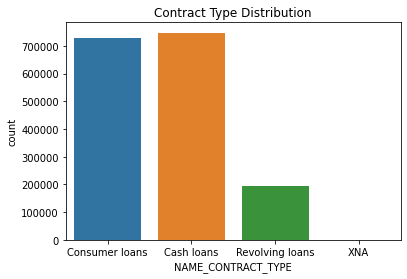

In [0]:
ax = sns.countplot(x="NAME_CONTRACT_TYPE", data=appsDF).set(title="Contract Type Distribution")

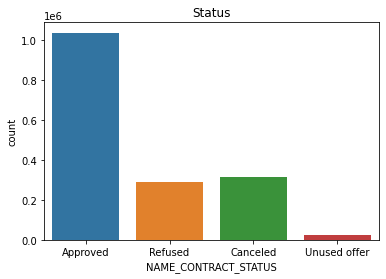

In [0]:
ax = sns.countplot(x="NAME_CONTRACT_STATUS", data=appsDF).set(title="Status")


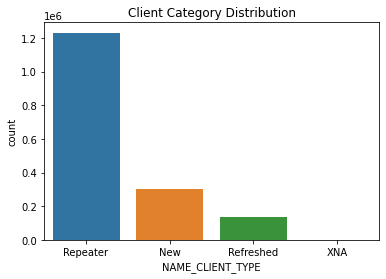

In [0]:
ax = sns.countplot(x="NAME_CLIENT_TYPE", data=appsDF).set(title="Client Category Distribution")

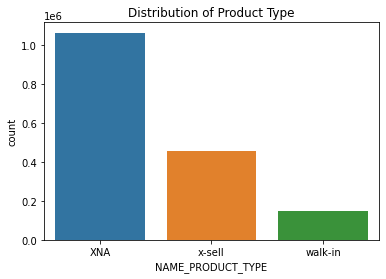

In [0]:
ax = sns.countplot(x="NAME_PRODUCT_TYPE", data=appsDF).set(title="Distribution of Product Type")

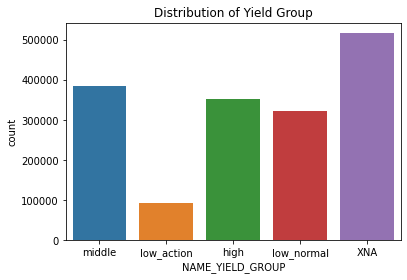

In [0]:
ax = sns.countplot(x="NAME_YIELD_GROUP", data=appsDF).set(title="Distribution of Yield Group")

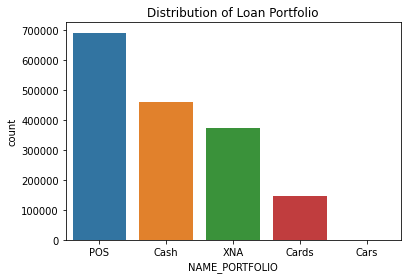

In [0]:
ax = sns.countplot(x="NAME_PORTFOLIO", data=appsDF).set(title="Distribution of Loan Portfolio")

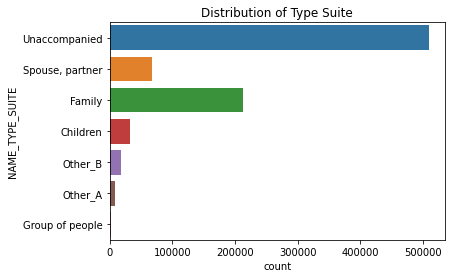

In [0]:
ax = sns.countplot(y="NAME_TYPE_SUITE", data=appsDF).set(title="Distribution of Type Suite")

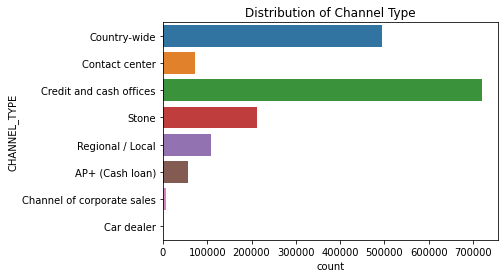

In [0]:
ax = sns.countplot(y="CHANNEL_TYPE", data=appsDF).set(title="Distribution of Channel Type")

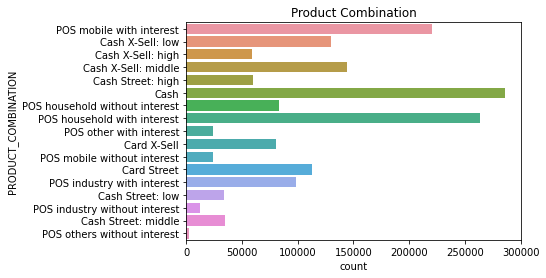

In [0]:
ax = sns.countplot(y="PRODUCT_COMBINATION", data=appsDF).set(title="Product Combination")

### Numerical Data

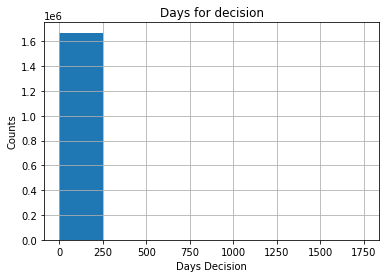

In [0]:
bins = np.arange(0,2000,250)
ax = plt.hist(np.clip(appsDF["DAYS_DECISION"], bins[0], bins[-1]), bins=bins)
plt.xlabel('Days Decision')
plt.ylabel('Counts')
plt.title('Days for decision')
plt.grid(True)
plt.show()

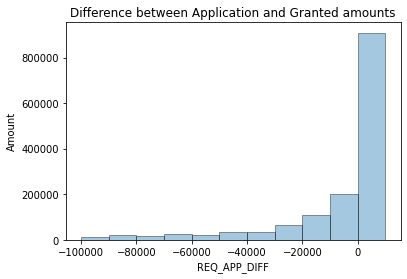

In [0]:
appsDF["REQ_APP_DIFF"] = appsDF["AMT_APPLICATION"] - appsDF["AMT_CREDIT"]
bins = np.arange(-100000,20000,10000)
plt.ylabel('Amount')
plt.title('Difference between Application and Granted amounts')
sns.distplot(appsDF["REQ_APP_DIFF"], hist=True, kde=False, 
             bins=bins,hist_kws={'edgecolor':'black'})
plt.show()

In [0]:
features = ['SK_ID_CURR','SK_ID_PREV','AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'REQ_APP_DIFF','RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
        'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']

In [0]:
appsNum = appsDF[features]
appl = appsNum.groupby(['SK_ID_CURR']).agg(['nunique','mean', 'count', 'std', 'sum', 'min', 'max'])
appl.columns = [ '_'.join(str(i) for i in col) for col in appl.columns]
appl.reset_index(inplace=True)

In [0]:
appl["APPL_RANGE"] = appl["AMT_APPLICATION_max"] - appl["AMT_APPLICATION_min"]

In [0]:
appl.head()

,SK_ID_CURR,SK_ID_PREV_nunique,SK_ID_PREV_mean,SK_ID_PREV_count,SK_ID_PREV_std,SK_ID_PREV_sum,SK_ID_PREV_min,SK_ID_PREV_max,AMT_ANNUITY_nunique,AMT_ANNUITY_mean,AMT_ANNUITY_count,AMT_ANNUITY_std,AMT_ANNUITY_sum,AMT_ANNUITY_min,AMT_ANNUITY_max,AMT_APPLICATION_nunique,AMT_APPLICATION_mean,AMT_APPLICATION_count,AMT_APPLICATION_std,AMT_APPLICATION_sum,AMT_APPLICATION_min,AMT_APPLICATION_max,AMT_CREDIT_nunique,AMT_CREDIT_mean,AMT_CREDIT_count,AMT_CREDIT_std,AMT_CREDIT_sum,AMT_CREDIT_min,AMT_CREDIT_max,AMT_DOWN_PAYMENT_nunique,AMT_DOWN_PAYMENT_mean,AMT_DOWN_PAYMENT_count,AMT_DOWN_PAYMENT_std,AMT_DOWN_PAYMENT_sum,AMT_DOWN_PAYMENT_min,AMT_DOWN_PAYMENT_max,AMT_GOODS_PRICE_nunique,AMT_GOODS_PRICE_mean,AMT_GOODS_PRICE_count,AMT_GOODS_PRICE_std,AMT_GOODS_PRICE_sum,AMT_GOODS_PRICE_min,AMT_GOODS_PRICE_max,REQ_APP_DIFF_nunique,REQ_APP_DIFF_mean,REQ_APP_DIFF_count,REQ_APP_DIFF_std,REQ_APP_DIFF_sum,REQ_APP_DIFF_min,REQ_APP_DIFF_max,RATE_DOWN_PAYMENT_nunique,RATE_DOWN_PAYMENT_mean,RATE_DOWN_PAYMENT_count,RATE_DOWN_PAYMENT_std,RATE_DOWN_PAYMENT_sum,RATE_DOWN_PAYMENT_min,RATE_DOWN_PAYMENT_max,RATE_INTEREST_PRIMARY_nunique,RATE_INTEREST_PRIMARY_mean,RATE_INTEREST_PRIMARY_count,RATE_INTEREST_PRIMARY_std,RATE_INTEREST_PRIMARY_sum,RATE_INTEREST_PRIMARY_min,RATE_INTEREST_PRIMARY_max,RATE_INTEREST_PRIVILEGED_nunique,RATE_INTEREST_PRIVILEGED_mean,RATE_INTEREST_PRIVILEGED_count,RATE_INTEREST_PRIVILEGED_std,RATE_INTEREST_PRIVILEGED_sum,RATE_INTEREST_PRIVILEGED_min,RATE_INTEREST_PRIVILEGED_max,DAYS_DECISION_nunique,DAYS_DECISION_mean,DAYS_DECISION_count,DAYS_DECISION_std,DAYS_DECISION_sum,DAYS_DECISION_min,DAYS_DECISION_max,CNT_PAYMENT_nunique,CNT_PAYMENT_mean,CNT_PAYMENT_count,CNT_PAYMENT_std,CNT_PAYMENT_sum,CNT_PAYMENT_min,CNT_PAYMENT_max,DAYS_FIRST_DRAWING_nunique,DAYS_FIRST_DRAWING_mean,DAYS_FIRST_DRAWING_count,DAYS_FIRST_DRAWING_std,DAYS_FIRST_DRAWING_sum,DAYS_FIRST_DRAWING_min,DAYS_FIRST_DRAWING_max,DAYS_FIRST_DUE_nunique,DAYS_FIRST_DUE_mean,DAYS_FIRST_DUE_count,DAYS_FIRST_DUE_std,DAYS_FIRST_DUE_sum,DAYS_FIRST_DUE_min,DAYS_FIRST_DUE_max,DAYS_LAST_DUE_1ST_VERSION_nunique,DAYS_LAST_DUE_1ST_VERSION_mean,DAYS_LAST_DUE_1ST_VERSION_count,DAYS_LAST_DUE_1ST_VERSION_std,DAYS_LAST_DUE_1ST_VERSION_sum,DAYS_LAST_DUE_1ST_VERSION_min,DAYS_LAST_DUE_1ST_VERSION_max,DAYS_LAST_DUE_nunique,DAYS_LAST_DUE_mean,DAYS_LAST_DUE_count,DAYS_LAST_DUE_std,DAYS_LAST_DUE_sum,DAYS_LAST_DUE_min,DAYS_LAST_DUE_max,DAYS_TERMINATION_nunique,DAYS_TERMINATION_mean,DAYS_TERMINATION_count,DAYS_TERMINATION_std,DAYS_TERMINATION_sum,DAYS_TERMINATION_min,DAYS_TERMINATION_max,APPL_RANGE
0,100001,1,1.369693e+06,1,NaN,1369693,1369693,1369693,1,3951.000000,1,NaN,3951.000000,3951.000000,3951.000000,1,24835.50,1,NaN,24835.5,24835.5,24835.5,1,23787.00,1,NaN,23787.0,23787.0,23787.0,1,2520.0,1,NaN,2520.0,2520.0,2520.0,1,24835.5,1,NaN,24835.5,24835.5,24835.5,1,1048.5,1,NaN,1048.5,1048.5,1048.5,1,0.104309,1,NaN,0.104309,0.104309,0.104309,0,NaN,0,NaN,0.0,NaN,NaN,0,NaN,0,NaN,0.0,NaN,NaN,1,-1740.0,1,NaN,-1740.0,-1740,-1740,1,8.0,1,NaN,8.0,8.0,8.0,1,365243.0,1,NaN,365243.0,365243.0,365243.0,1,-1709.000000,1,NaN,-1709.0,-1709.0,-1709.0,1,-1499.000000,1,NaN,-1499.0,-1499.0,-1499.0,1,-1619.000000,1,NaN,-1619.0,-1619.0,-1619.0,1,-1612.000000,1,NaN,-1612.0,-1612.0,-1612.0,0.0
1,100002,1,1.038818e+06,1,NaN,1038818,1038818,1038818,1,9251.775391,1,NaN,9251.775391,9251.775391,9251.775391,1,179055.00,1,NaN,179055.0,179055.0,179055.0,1,179055.00,1,NaN,179055.0,179055.0,179055.0,1,0.0,1,NaN,0.0,0.0,0.0,1,179055.0,1,NaN,179055.0,179055.0,179055.0,1,0.0,1,NaN,0.0,0.0,0.0,1,0.000000,1,NaN,0.000000,0.000000,0.000000,0,NaN,0,NaN,0.0,NaN,NaN,0,NaN,0,NaN,0.0,NaN,NaN,1,-606.0,1,NaN,-606.0,-606,-606,1,24.0,1,NaN,24.0,24.0,24.0,1,365243.0,1,NaN,365243.0,365243.0,365243.0,1,-565.000000,1,NaN,-565.0,-565.0,-565.0,1,125.000000,1,NaN,125.0,125.0,125.0,1,-25.000000,1,NaN,-25.0,-25.0,-25.0,1,-17.000000,1,NaN,-17.0,-17.0,-17.0,0.0
2,100003,3,2.281150e+06,3,424796.348991,6843451,1810518,2636178,3,56553.988281,3,46332.554688,169661.968750,

### Target Correlation

In [0]:
applTrain = appl.set_index('SK_ID_CURR').join(other1.set_index('SK_ID_CURR'))

In [0]:
applTrain.shape

(338857, 121)

In [0]:
correlations = applTrain.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 RATE_INTEREST_PRIVILEGED_mean     0.031139
DAYS_LAST_DUE_1ST_VERSION_mean    0.031203
RATE_INTEREST_PRIVILEGED_max      0.031420
DAYS_FIRST_DRAWING_nunique        0.041077
DAYS_LAST_DUE_1ST_VERSION_std     0.041546
DAYS_DECISION_mean                0.046864
CNT_PAYMENT_std                   0.048335
DAYS_DECISION_min                 0.053434
DAYS_FIRST_DRAWING_std            0.067594
TARGET                            1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 DAYS_DECISION_std          -0.059792
DAYS_FIRST_DRAWING_mean    -0.048803
DAYS_FIRST_DRAWING_min     -0.044643
RATE_DOWN_PAYMENT_sum      -0.041693
DAYS_FIRST_DRAWING_sum     -0.041671
RATE_DOWN_PAYMENT_max      -0.040095
DAYS_TERMINATION_nunique   -0.035970
DAYS_LAST_DUE_nunique      -0.035396
AMT_ANNUITY_mean           -0.034871
AMT_DOWN_PAYMENT_nunique   -0.034858
Name: TARGET, dtype: float64


## POS_cash_balanace

### Summary

In [11]:
POS_CASH_balance=datasets["POS_CASH_balance"]
day_convert(POS_CASH_balance)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


In [12]:
POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int32
SK_ID_CURR               int32
MONTHS_BALANCE           int8
CNT_INSTALMENT           float16
CNT_INSTALMENT_FUTURE    float16
NAME_CONTRACT_STATUS     object
SK_DPD                   int16
SK_DPD_DEF               int16
dtypes: float16(2), int16(2), int32(2), int8(1), object(1)
memory usage: 238.5+ MB


In [13]:
#removing all rows where CNT_INSTALMENT_FUTURE = 0
zeros = POS_CASH_balance[ POS_CASH_balance['CNT_INSTALMENT_FUTURE'] == 0.0 ].index
POS_CASH_balance.drop(zeros , inplace=True)

In [14]:
POS_CASH_balance.describe(include='all') # numerical and categorical features

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,8.815398e+06,8.815398e+06,8.815398e+06,8789327.0,8789311.0,8815398,8.815398e+06,8.815398e+06
unique,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,8718618,NaN,NaN
mean,1.903373e+06,2.783789e+05,-3.436210e+01,NaN,NaN,NaN,1.443824e-01,6.908695e-02
std,5.357622e+05,1.027664e+05,2.568452e+01,0.0,0.0,NaN,1.626021e+00,1.064389e+00
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.0,1.0,NaN,0.000000e+00,0.000000e+00
25%,1.434580e+06,1.894960e+05,-5.300000e+01,10.0,4.0,NaN,0.000000e+00,0.000000e+00
50%,1.896792e+06,2.786570e+05,-2.700000e+01,12.0,8.0,NaN,0.000000e+00,0.000000e+00
75%,2.368951e+06,3.674028e+05,-1.300000e+01,24.0,16.0,NaN,0.000000e+00,0.000000e+00


In [0]:
POS_CASH_balance.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [15]:
# unique catagorical variable values:
print('NAME_CONTRACT_STATUS'," ",POS_CASH_balance['NAME_CONTRACT_STATUS'].unique())

NAME_CONTRACT_STATUS   ['Active' 'Signed' 'Approved' 'Returned to the store' 'Canceled' 'Demand'
 'XNA' 'Completed']


In [0]:
POS_CASH_balance.NAME_CONTRACT_STATUS.value_counts()

Active                   8718618
Signed                     86420
Returned to the store       5461
Approved                    4862
Demand                        16
Canceled                      15
Completed                      4
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [37]:
apps = datasets["application_train"]
apps1= apps[['SK_ID_CURR', 'TARGET']]
posapps = POS_CASH_balance.set_index('SK_ID_CURR').join(apps1.set_index('SK_ID_CURR'))

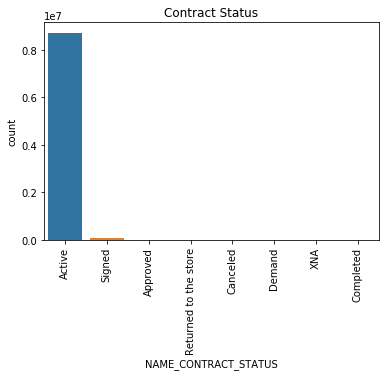

In [16]:
sns.countplot(x='NAME_CONTRACT_STATUS', data=POS_CASH_balance);
plt.title('Contract Status');
plt.xticks(rotation=90);

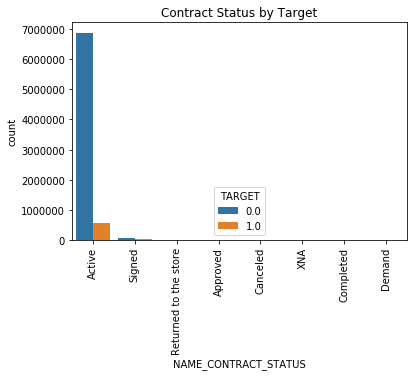

In [35]:
sns.countplot(x='NAME_CONTRACT_STATUS',hue='TARGET', data=posapps);
plt.title('Contract Status by Target');
plt.xticks(rotation=90);

In [0]:
POS_CASH_balance['INSTALLMENTS_MADE'] = POS_CASH_balance.CNT_INSTALMENT - POS_CASH_balance.CNT_INSTALMENT_FUTURE

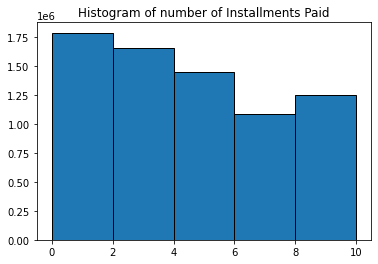

In [0]:
bins= [0,2,4,6,8,10]
plt.hist(POS_CASH_balance.INSTALLMENTS_MADE, bins=bins, edgecolor="k")
plt.xticks(bins)
plt.title('Histogram of number of Installments Paid')
plt.show()

In [29]:
POS_CASH_balance['INSTALLMENT_TIME']=["On-time" if x <= 0 else "Late" for x in POS_CASH_balance.SK_DPD]

Text(0.5, 1.0, 'Times installment was paid after due date')

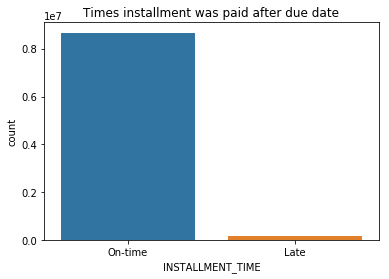

In [30]:
sns.countplot(x="INSTALLMENT_TIME", data=POS_CASH_balance)
plt.title("Times installment was paid after due date")

In [33]:
posapps['INSTALLMENT_TIME']=["On-time" if x <= 0 else "Late" for x in POS_CASH_balance.SK_DPD]

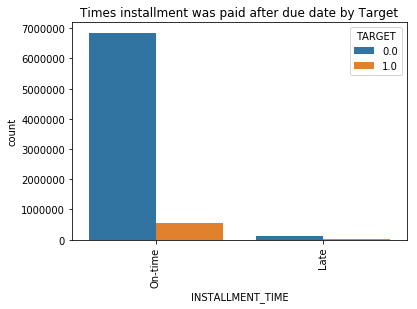

In [40]:
sns.countplot(x="INSTALLMENT_TIME",hue='TARGET', data=posapps);
plt.title('Times installment was paid after due date by Target');
plt.xticks(rotation=90);

In [0]:
cash_bal = POS_CASH_balance.groupby(['SK_ID_CURR']).agg(['mean', 'count', 'std', 'sum', 'min', 'max'])
cash_bal.columns = [ '_'.join(str(i) for i in col) for col in cash_bal.columns]
cash_bal.reset_index(inplace=True)
cash_bal

,SK_ID_CURR,SK_ID_PREV_mean,SK_ID_PREV_count,SK_ID_PREV_std,SK_ID_PREV_sum,SK_ID_PREV_min,SK_ID_PREV_max,MONTHS_BALANCE_mean,MONTHS_BALANCE_count,MONTHS_BALANCE_std,MONTHS_BALANCE_sum,MONTHS_BALANCE_min,MONTHS_BALANCE_max,CNT_INSTALMENT_mean,CNT_INSTALMENT_count,CNT_INSTALMENT_std,CNT_INSTALMENT_sum,CNT_INSTALMENT_min,CNT_INSTALMENT_max,CNT_INSTALMENT_FUTURE_mean,CNT_INSTALMENT_FUTURE_count,CNT_INSTALMENT_FUTURE_std,CNT_INSTALMENT_FUTURE_sum,CNT_INSTALMENT_FUTURE_min,CNT_INSTALMENT_FUTURE_max,SK_DPD_mean,SK_DPD_count,SK_DPD_std,SK_DPD_sum,SK_DPD_min,SK_DPD_max,SK_DPD_DEF_mean,SK_DPD_DEF_count,SK_DPD_DEF_std,SK_DPD_DEF_sum,SK_DPD_DEF_min,SK_DPD_DEF_max,INSTALLMENTS_MADE_mean,INSTALLMENTS_MADE_count,INSTALLMENTS_MADE_std,INSTALLMENTS_MADE_sum,INSTALLMENTS_MADE_min,INSTALLMENTS_MADE_max
0,100001,1.530457e+06,6,249054.001470,9182740,1369693,1851984,-68.833333,6,20.682521,-413.0,-96,-54,4.000000,6,0.000000,24.0,4.0,4.0,2.166016,6,1.168945,13.0,1.0,4.0,1.166667,6,2.857738,7,0,7,1.166667,6,2.857738,7,0,7,1.833008,6,1.168945,11.0,0.0,3.0
1,100002,1.038818e+06,19,0.000000,19737542,1038818,1038818,-10.000000,19,5.627314,-190.0,-19,-1,24.000000,19,0.000000,456.0,24.0,24.0,15.000000,19,5.628906,285.0,6.0,24.0,0.000000,19,0.000000,0,0,0,0.000000,19,0.000000,0,0,0,9.000000,19,5.628906,171.0,0.0,18.0
2,100003,2.290070e+06,25,320488.923470,57251754,1810518,2636178,-46.600000,25,24.610296,-1165.0,-77,-19,10.562500,25,2.615234,264.0,6.0,12.0,6.480469,25,3.453125,162.0,1.0,12.0,0.000000,25,0.000000,0,0,0,0.000000,25,0.000000,0,0,0,4.078125,25,3.134766,102.0,0.0,11.0
3,100004,1.564014e+06,3,0.000000,4692042,1564014,1564014,-26.000000,3,1.000000,-78.0,-27,-25,4.000000,3,0.000000,12.0,4.0,4.0,3.000000,3,1.000000,9.0,2.0,4.0,0.000000,3,0.000000,0,0,0,0.000000,3,0.000000,0,0,0,1.000000,3,1.000000,3.0,0.0,2.0
4,100005,2.495675e+06,10,0.000000,24956750,2495675,2495675,-20.500000,10,3.027650,-205.0,-25,-16,12.000000,9,0.000000,108.0,12.0,12.0,8.000000,9,2.738281,72.0,4.0,12.0,0.000000,10,0.000000,0,0,0,0.000000,10,0.000000,0,0,0,4.000000,9,2.738281,36.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336604,456251,2.248017e+06,8,0.000000,17984136,2248017,2248017,-5.500000,8,2.449490,-44.0,-9,-2,8.000000,7,0.000000,56.0,8.0,8.0,5.000000,7,2.160156,35.0,2.0,8.0,0.000000,8,0.000000,0,0,0,0.000000,8,0.000000,0,0,0,3.000000,7,2.160156,21.0,0.0,6.0
336605,456252,1.503599e+06,6,0.000000,9021594,1503599,1503599,-79.500000,6,1.870829,-477.0,-82,-77,6.000000,6,0.000000,36.0,6.0,6.0,3.500000,6,1.871094,21.0,1.0,6.0,0.000000,6,0.000000,0,0,0,0.000000,6,0.000000,0,0,0,2.500000,6,1.871094,15.0,0.0,5.0
336606,456253,1.737400e+06,12,136607.906630,20848796,1668235,2029307,-77.000000,12,17.325756,-924.0,-96,-58,6.332031,12,2.806641,76.0,4.0,12.0,2.833984,12,1.642578,34.0,1.0,6.0,0.416667,12,1.443376,5,0,5,0.416667,12,1.443376,5,0,5,3.500000,12,3.605469,42.0,0.0,11.0
336607,456254,1.893484e+06,20,114076.843814,37869673,1792910,2016407,-5.550000,20,3.034451,-111.0,-11,-1,14.898438,20,1.020508,298.0,14.0,16.0,10.351562,20,3.359375,207.0,4.0,16.0,0.000000,20,0.000000,0,0,0,0.000000,20,0.000000,0,0,0,4.550781,20,3.035156,91.0,0.0,10.0


### Target Corelation

In [0]:
cash_balTrain = POS_CASH_balance.set_index('SK_ID_CURR').join(other1.set_index('SK_ID_CURR'))
correlations = cash_balTrain.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 INSTALLMENTS_MADE       -0.004985
SK_ID_PREV              -0.000371
SK_DPD                   0.014750
SK_DPD_DEF               0.017795
MONTHS_BALANCE           0.019468
CNT_INSTALMENT           0.021332
CNT_INSTALMENT_FUTURE    0.026114
TARGET                   1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 INSTALLMENTS_MADE       -0.004985
SK_ID_PREV              -0.000371
SK_DPD                   0.014750
SK_DPD_DEF               0.017795
MONTHS_BALANCE           0.019468
CNT_INSTALMENT           0.021332
CNT_INSTALMENT_FUTURE    0.026114
TARGET                   1.000000
Name: TARGET, dtype: float64


## credit_card_balance

### Summary

In [42]:
credit_bal = datasets["credit_card_balance"]
day_convert(credit_bal)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.500000,0.0,877.500000,1700.324951,1800.000000,1800.000000,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.000000,0.0,0.000000,2250.000000,2250.000000,2250.000000,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.000000,0.0,0.000000,2250.000000,2250.000000,2250.000000,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.000000,0.0,0.000000,11795.759766,11925.000000,11925.000000,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.000000,0.0,11547.000000,22924.890625,27000.000000,27000.000000,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.812500,270000,0.0,0.000000,0.0,0.000000,4449.104980,3825.000000,3825.000000,80519.039062,82773.312500,82773.312500,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.656250,585000,67500.0,67500.000000,0.0,0.000000,14684.174805,15750.000000,15750.000000,345433.875000,351881.156250,351881.156250,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125000,45000,45000.0,45000.000000,0.0,0.000000,0.000000,264.690002,0.000000,44735.308594,47962.125000,47962.125000,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.062500,292500,90000.0,289339.437500,0.0,199339.421875,130.500000,4093.514893,4093.514893,285376.406250,286831.562500,286831.562500,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.187500,225000,76500.0,111026.703125,0.0,34526.699219,6338.339844,45000.000000,45000.000000,192793.281250,197224.687500,197224.687500,3.0,9,0.0,6.0,38.0,Active,0,0


In [0]:
credit_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int32  
 1   SK_ID_CURR                  int32  
 2   MONTHS_BALANCE              int8   
 3   AMT_BALANCE                 float32
 4   AMT_CREDIT_LIMIT_ACTUAL     int32  
 5   AMT_DRAWINGS_ATM_CURRENT    float32
 6   AMT_DRAWINGS_CURRENT        float32
 7   AMT_DRAWINGS_OTHER_CURRENT  float32
 8   AMT_DRAWINGS_POS_CURRENT    float32
 9   AMT_INST_MIN_REGULARITY     float32
 10  AMT_PAYMENT_CURRENT         float32
 11  AMT_PAYMENT_TOTAL_CURRENT   float32
 12  AMT_RECEIVABLE_PRINCIPAL    float32
 13  AMT_RECIVABLE               float32
 14  AMT_TOTAL_RECEIVABLE        float32
 15  CNT_DRAWINGS_ATM_CURRENT    float16
 16  CNT_DRAWINGS_CURRENT        int16  
 17  CNT_DRAWINGS_OTHER_CURRENT  float16
 18  CNT_DRAWINGS_POS_CURRENT    float16
 19  CNT_INSTALMENT_MATURE

In [0]:
credit_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [0]:
credit_bal.describe(include='all') # numerical and categorical features

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.072324e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3090496.0,3.840312e+06,3.090496e+06,3090496.0,3535076.0,3840312,3.840312e+06,3.840312e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.827686e+04,1.538080e+05,5.962299e+03,7.432263e+03,2.881647e+02,2.968840e+03,3.541778e+03,1.021103e+04,7.564767e+03,5.595036e+04,5.808502e+04,5.809459e+04,NaN,7.031439e-01,4.810333e-03,NaN,NaN,NaN,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.074641e+05,1.651457e+05,2.803397e+04,3.336682e+04,8.197021e+03,2.066321e+04,5.525350e+03,3.579142e+04,3.159429e+04,1.015177e+05,1.071769e+05,1.071802e+05,0.0,3.190347e+00,8.239746e-02,0.0,0.0,NaN,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.0,0.000000e+00,0.000000e+00,0.0,0.0,NaN,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.523700e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,4.0,NaN,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.702700e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,15.0,NaN,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,9.000000e+03,6.750000e+03,8.535924e+04,8.889949e+04,8.891451e+04,0.0,0.000000e+00,0.000000e+00,0.0,32.0,NaN,0.000000e+00,0.000000e+00


In [0]:
credit_bal.isna().sum()

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

In [0]:
# unique catagorical variable values:
print('NAME_CONTRACT_STATUS'," ",credit_bal['NAME_CONTRACT_STATUS'].unique())

NAME_CONTRACT_STATUS   ['Active' 'Completed' 'Demand' 'Signed' 'Sent proposal' 'Refused'
 'Approved']


In [0]:
credit_bal.NAME_CONTRACT_STATUS.value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

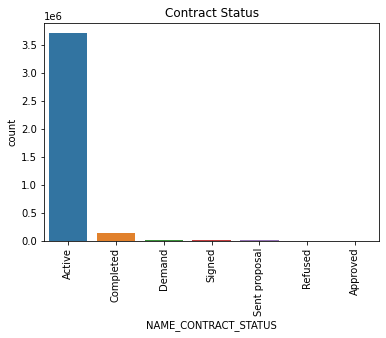

In [0]:
sns.countplot(x='NAME_CONTRACT_STATUS', data=credit_bal);
plt.title('Contract Status');
plt.xticks(rotation=90);

In [44]:
apps2 = datasets["application_train"]
apps3= apps[['SK_ID_CURR', 'TARGET']]
credit_joined = credit_bal.set_index('SK_ID_CURR').join(apps3.set_index('SK_ID_CURR'))

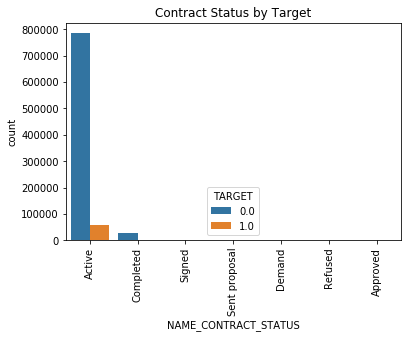

In [45]:
sns.countplot(x='NAME_CONTRACT_STATUS',hue='TARGET', data=credit_joined);
plt.title('Contract Status by Target');
plt.xticks(rotation=90);

In [0]:
credit_bal["TOTAL_SPENT_PREV_MONTH"] = credit_bal.AMT_DRAWINGS_ATM_CURRENT + credit_bal.AMT_DRAWINGS_CURRENT + credit_bal.AMT_DRAWINGS_OTHER_CURRENT + credit_bal.AMT_DRAWINGS_POS_CURRENT

In [0]:
credit_bal["CREDIT_LEFT_PREV_MONTH"] = credit_bal.AMT_CREDIT_LIMIT_ACTUAL - credit_bal.TOTAL_SPENT_PREV_MONTH

In [0]:
credit_bal["AMT_LEFT"] = credit_bal.AMT_TOTAL_RECEIVABLE - credit_bal.AMT_PAYMENT_TOTAL_CURRENT

In [0]:
credit_bal['LATE_INSTALLMENT']=["On-time" if x <= 0 else "Late" for x in credit_bal.SK_DPD]

[Text(0.5, 1.0, 'Times installment was paid after due date')]

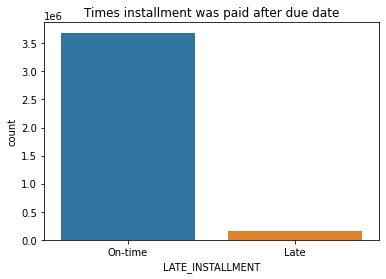

In [0]:
sns.countplot(x="LATE_INSTALLMENT", data=credit_bal).set(title="Times installment was paid after due date")

In [46]:
credit_joined['LATE_INSTALLMENT']=["On-time" if x <= 0 else "Late" for x in credit_bal.SK_DPD]

[Text(0.5, 1.0, 'Times installment was paid after due date by Target')]

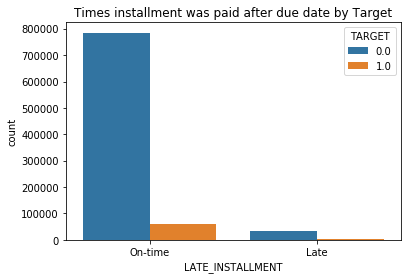

In [54]:
sns.countplot(x="LATE_INSTALLMENT", hue='TARGET' , data=credit_joined).set(title="Times installment was paid after due date by Target")

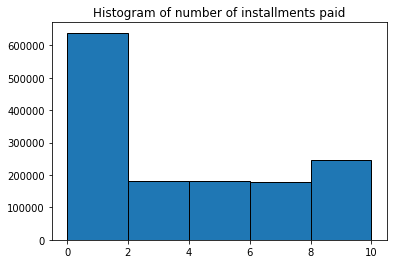

In [0]:
bins= [0,2,4,6,8,10]
plt.hist(credit_bal['CNT_INSTALMENT_MATURE_CUM'], bins=bins, edgecolor="k")
plt.xticks(bins)
plt.title('Times installment was paid after due date by Targer')
plt.show()

In [0]:
card_bal = credit_bal.groupby(['SK_ID_CURR']).agg(['mean', 'count', 'std', 'sum', 'min', 'max'])
card_bal.columns = [ '_'.join(str(i) for i in col) for col in card_bal.columns]
card_bal.reset_index(inplace=True)
card_bal

,SK_ID_CURR,SK_ID_PREV_mean,SK_ID_PREV_count,SK_ID_PREV_std,SK_ID_PREV_sum,SK_ID_PREV_min,SK_ID_PREV_max,MONTHS_BALANCE_mean,MONTHS_BALANCE_count,MONTHS_BALANCE_std,MONTHS_BALANCE_sum,MONTHS_BALANCE_min,MONTHS_BALANCE_max,AMT_BALANCE_mean,AMT_BALANCE_count,AMT_BALANCE_std,AMT_BALANCE_sum,AMT_BALANCE_min,AMT_BALANCE_max,AMT_CREDIT_LIMIT_ACTUAL_mean,AMT_CREDIT_LIMIT_ACTUAL_count,AMT_CREDIT_LIMIT_ACTUAL_std,AMT_CREDIT_LIMIT_ACTUAL_sum,AMT_CREDIT_LIMIT_ACTUAL_min,AMT_CREDIT_LIMIT_ACTUAL_max,AMT_DRAWINGS_ATM_CURRENT_mean,AMT_DRAWINGS_ATM_CURRENT_count,AMT_DRAWINGS_ATM_CURRENT_std,AMT_DRAWINGS_ATM_CURRENT_sum,AMT_DRAWINGS_ATM_CURRENT_min,AMT_DRAWINGS_ATM_CURRENT_max,AMT_DRAWINGS_CURRENT_mean,AMT_DRAWINGS_CURRENT_count,AMT_DRAWINGS_CURRENT_std,AMT_DRAWINGS_CURRENT_sum,AMT_DRAWINGS_CURRENT_min,AMT_DRAWINGS_CURRENT_max,AMT_DRAWINGS_OTHER_CURRENT_mean,AMT_DRAWINGS_OTHER_CURRENT_count,AMT_DRAWINGS_OTHER_CURRENT_std,AMT_DRAWINGS_OTHER_CURRENT_sum,AMT_DRAWINGS_OTHER_CURRENT_min,AMT_DRAWINGS_OTHER_CURRENT_max,AMT_DRAWINGS_POS_CURRENT_mean,AMT_DRAWINGS_POS_CURRENT_count,AMT_DRAWINGS_POS_CURRENT_std,AMT_DRAWINGS_POS_CURRENT_sum,AMT_DRAWINGS_POS_CURRENT_min,AMT_DRAWINGS_POS_CURRENT_max,AMT_INST_MIN_REGULARITY_mean,AMT_INST_MIN_REGULARITY_count,AMT_INST_MIN_REGULARITY_std,AMT_INST_MIN_REGULARITY_sum,AMT_INST_MIN_REGULARITY_min,AMT_INST_MIN_REGULARITY_max,AMT_PAYMENT_CURRENT_mean,AMT_PAYMENT_CURRENT_count,AMT_PAYMENT_CURRENT_std,AMT_PAYMENT_CURRENT_sum,AMT_PAYMENT_CURRENT_min,AMT_PAYMENT_CURRENT_max,AMT_PAYMENT_TOTAL_CURRENT_mean,AMT_PAYMENT_TOTAL_CURRENT_count,AMT_PAYMENT_TOTAL_CURRENT_std,AMT_PAYMENT_TOTAL_CURRENT_sum,AMT_PAYMENT_TOTAL_CURRENT_min,AMT_PAYMENT_TOTAL_CURRENT_max,AMT_RECEIVABLE_PRINCIPAL_mean,AMT_RECEIVABLE_PRINCIPAL_count,AMT_RECEIVABLE_PRINCIPAL_std,AMT_RECEIVABLE_PRINCIPAL_sum,AMT_RECEIVABLE_PRINCIPAL_min,AMT_RECEIVABLE_PRINCIPAL_max,AMT_RECIVABLE_mean,AMT_RECIVABLE_count,AMT_RECIVABLE_std,AMT_RECIVABLE_sum,AMT_RECIVABLE_min,AMT_RECIVABLE_max,AMT_TOTAL_RECEIVABLE_mean,AMT_TOTAL_RECEIVABLE_count,AMT_TOTAL_RECEIVABLE_std,AMT_TOTAL_RECEIVABLE_sum,AMT_TOTAL_RECEIVABLE_min,AMT_TOTAL_RECEIVABLE_max,CNT_DRAWINGS_ATM_CURRENT_mean,CNT_DRAWINGS_ATM_CURRENT_count,CNT_DRAWINGS_ATM_CURRENT_std,CNT_DRAWINGS_ATM_CURRENT_sum,CNT_DRAWINGS_ATM_CURRENT_min,CNT_DRAWINGS_ATM_CURRENT_max,CNT_DRAWINGS_CURRENT_mean,CNT_DRAWINGS_CURRENT_count,CNT_DRAWINGS_CURRENT_std,CNT_DRAWINGS_CURRENT_sum,CNT_DRAWINGS_CURRENT_min,CNT_DRAWINGS_CURRENT_max,CNT_DRAWINGS_OTHER_CURRENT_mean,CNT_DRAWINGS_OTHER_CURRENT_count,CNT_DRAWINGS_OTHER_CURRENT_std,CNT_DRAWINGS_OTHER_CURRENT_sum,CNT_DRAWINGS_OTHER_CURRENT_min,CNT_DRAWINGS_OTHER_CURRENT_max,CNT_DRAWINGS_POS_CURRENT_mean,CNT_DRAWINGS_POS_CURRENT_count,CNT_DRAWINGS_POS_CURRENT_std,CNT_DRAWINGS_POS_CURRENT_sum,CNT_DRAWINGS_POS_CURRENT_min,CNT_DRAWINGS_POS_CURRENT_max,CNT_INSTALMENT_MATURE_CUM_mean,CNT_INSTALMENT_MATURE_CUM_count,CNT_INSTALMENT_MATURE_CUM_std,CNT_INSTALMENT_MATURE_CUM_sum,CNT_INSTALMENT_MATURE_CUM_min,CNT_INSTALMENT_MATURE_CUM_max,SK_DPD_mean,SK_DPD_count,SK_DPD_std,SK_DPD_sum,SK_DPD_min,SK_DPD_max,SK_DPD_DEF_mean,SK_DPD_DEF_count,SK_DPD_DEF_std,SK_DPD_DEF_sum,SK_DPD_DEF_min,SK_DPD_DEF_max,TOTAL_SPENT_PREV_MONTH_mean,TOTAL_SPENT_PREV_MONTH_count,TOTAL_SPENT_PREV_MONTH_std,TOTAL_SPENT_PREV_MONTH_sum,TOTAL_SPENT_PREV_MONTH_min,TOTAL_SPENT_PREV_MONTH_max,CREDIT_LEFT_PREV_MONTH_mean,CREDIT_LEFT_PREV_MONTH_count,CREDIT_LEFT_PREV_MONTH_std,CREDIT_LEFT_PREV_MONTH_sum,CREDIT_LEFT_PREV_MONTH_min,CREDIT_LEFT_PREV_MONTH_max,AMT_LEFT_mean,AMT_LEFT_count,AMT_LEFT_std,AMT_LEFT_sum,AMT_LEFT_min,AMT_LEFT_max
0,100006,1489396.0,6,0.0,8936376,1489396,1489396,-3.5,6,1.870829,-21.0,-6,-1,0.000000,6,0.000000,0.000000e+00,0.00000,0.000000,270000.000000,6,0.000000,1620000,270000,270000,NaN,0,NaN,0.0,NaN,NaN,0.000000,6,0.000000,0.000000e+00,0.0,0.000000,NaN,0,NaN,0.0,NaN,NaN,NaN,0,NaN,0.000000,NaN,NaN,0.000000,6,0.000000,0.000000,0.0,0.000000,NaN,0,NaN,0.000000e+00,NaN,NaN,0.000000,6,0.000000,0.000000e+00,0.0,0.000000,0.000000

### Target Corelation

In [0]:
card_balTrain = credit_bal.set_index('SK_ID_CURR').join(other1.set_index('SK_ID_CURR'))
correlations = card_balTrain.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 MONTHS_BALANCE              0.035695
CNT_DRAWINGS_CURRENT        0.037793
CNT_DRAWINGS_ATM_CURRENT    0.038437
AMT_INST_MIN_REGULARITY     0.039798
AMT_LEFT                    0.046128
AMT_RECEIVABLE_PRINCIPAL    0.049692
AMT_RECIVABLE               0.049803
AMT_TOTAL_RECEIVABLE        0.049839
AMT_BALANCE                 0.050098
TARGET                      1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 CNT_INSTALMENT_MATURE_CUM    -0.023684
SK_DPD                        0.001684
SK_ID_PREV                    0.002571
CNT_DRAWINGS_OTHER_CURRENT    0.003044
AMT_DRAWINGS_OTHER_CURRENT    0.003843
AMT_DRAWINGS_POS_CURRENT      0.005084
SK_DPD_DEF                    0.010538
AMT_PAYMENT_TOTAL_CURRENT     0.012302
AMT_PAYMENT_CURRENT           0.012929
AMT_CREDIT_LIMIT_ACTUAL       0.013823
Name: TARGET, dtype: float64


## Installments Payments Dataset

### Summary

In [55]:
insDF = datasets["installments_payments"]

__Column information from Data Dictionary__
* __SK_ID_PREV__ 	ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
* __SK_ID_CURR__	ID of loan in our sample
* __NUM_INSTALMENT_VERSION__	Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
* __NUM_INSTALMENT_NUMBER__	On which installment we observe payment
* __DAYS_INSTALMENT__	When the installment of previous credit was supposed to be paid (relative to application date of current loan)
* __DAYS_ENTRY_PAYMENT__	When was the installments of previous credit paid actually (relative to application date of current loan)
* __AMT_INSTALMENT__	What was the prescribed installment amount of previous credit on this installment
* __AMT_PAYMENT__	What the client actually paid on previous credit on this installment

In [0]:
insDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int32  
 1   SK_ID_CURR              int32  
 2   NUM_INSTALMENT_VERSION  float16
 3   NUM_INSTALMENT_NUMBER   int16  
 4   DAYS_INSTALMENT         float16
 5   DAYS_ENTRY_PAYMENT      float16
 6   AMT_INSTALMENT          float32
 7   AMT_PAYMENT             float32
dtypes: float16(3), float32(2), int16(1), int32(2)
memory usage: 311.4 MB


In [0]:
insDF.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [61]:
# Convert days to positive values
day_convert(insDF)
insDF.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,1180.0,1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,2156.0,2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,63.0,63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,2418.0,2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,1383.0,1366.0,2165.040039,2160.584961


In [62]:
insDF['PAYMENT_DELAY']=insDF['DAYS_ENTRY_PAYMENT']-insDF['DAYS_INSTALMENT']
insDF['INSTALLMENT_DIFFERENCE']=insDF['AMT_PAYMENT']-insDF['AMT_INSTALMENT']
insDF['LATE_PAYMENT']=[0 if x <= 0 else 1 for x in insDF['PAYMENT_DELAY']]
insDF['EXTRA_PAYMENT']=[0 if x <= 0 else 1 for x in insDF['INSTALLMENT_DIFFERENCE']]

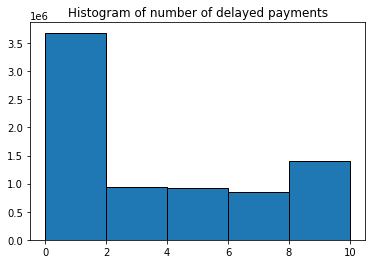

In [0]:
bins= [0,2,4,6,8,10]
plt.hist(insDF['PAYMENT_DELAY'], bins=bins, edgecolor="k")
plt.xticks(bins)
plt.title('Histogram of number of delayed payments')
plt.show()

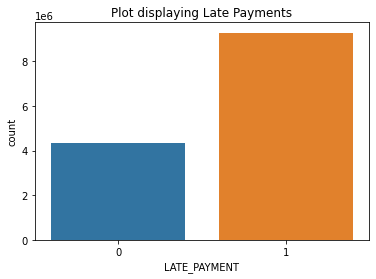

In [0]:
ax = sns.countplot(x="LATE_PAYMENT", data=insDF).set(title="Plot displaying Late Payments")

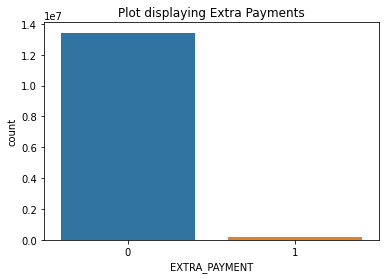

In [0]:
ax = sns.countplot(x="EXTRA_PAYMENT", data=insDF).set(title="Plot displaying Extra Payments")

In [0]:
# Check the data for 1 Current ID in the first million rows
insDF[0:1000000][(insDF["SK_ID_CURR"]==199697)]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAYMENT_DELAY,INSTALLMENT_DIFFERENCE,LATE_PAYMENT,EXTRA_PAYMENT
3,2452527,199697,1.0,3,2418.0,2426.0,24350.130859,24350.130859,8.0,0.000000,1,0
310435,2361855,199697,1.0,2,874.0,864.0,21179.699219,21164.400391,-10.0,-15.298828,0,0
381670,2361855,199697,1.0,9,664.0,663.0,21179.699219,21179.699219,-1.0,0.000000,0,0
806132,2361855,199697,1.0,7,724.0,707.0,21179.699219,21128.400391,-17.0,-51.298828,0,0
853630,2361855,199697,1.0,2,874.0,894.0,21179.699219,15.300000,20.0,-21164.398438,1,0
860430,2361855,199697,1.0,6,754.0,739.0,21179.699219,21143.699219,-15.0,-36.000000,0,0
949157,2452527,199697,1.0,5,2358.0,2368.0,24350.130859,24350.130859,10.0,0.000000,1,0
985427,2361855,199697,1.0,3,844.0,842.0,21179.699219,20969.099609,-2.0,-210.599609,0,0


In [0]:
instal = insDF.groupby(['SK_ID_CURR']).agg(['nunique','mean', 'count', 'std', 'sum', 'min', 'max'])
instal.columns = [ '_'.join(str(i) for i in col) for col in instal.columns]
instal.reset_index(inplace=True)

In [0]:
# Create a new feature - Number of missed installments -> Max Install number - total intallment count
instal['INSTALLMENTS_MISSED']=instal['NUM_INSTALMENT_NUMBER_max'] - instal['NUM_INSTALMENT_NUMBER_count']

In [0]:
instal.head()

,SK_ID_CURR,SK_ID_PREV_nunique,SK_ID_PREV_mean,SK_ID_PREV_count,SK_ID_PREV_std,SK_ID_PREV_sum,SK_ID_PREV_min,SK_ID_PREV_max,NUM_INSTALMENT_VERSION_nunique,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_count,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_NUMBER_nunique,NUM_INSTALMENT_NUMBER_mean,NUM_INSTALMENT_NUMBER_count,NUM_INSTALMENT_NUMBER_std,NUM_INSTALMENT_NUMBER_sum,NUM_INSTALMENT_NUMBER_min,NUM_INSTALMENT_NUMBER_max,DAYS_INSTALMENT_nunique,DAYS_INSTALMENT_mean,DAYS_INSTALMENT_count,DAYS_INSTALMENT_std,DAYS_INSTALMENT_sum,DAYS_INSTALMENT_min,DAYS_INSTALMENT_max,DAYS_ENTRY_PAYMENT_nunique,DAYS_ENTRY_PAYMENT_mean,DAYS_ENTRY_PAYMENT_count,DAYS_ENTRY_PAYMENT_std,DAYS_ENTRY_PAYMENT_sum,DAYS_ENTRY_PAYMENT_min,DAYS_ENTRY_PAYMENT_max,AMT_INSTALMENT_nunique,AMT_INSTALMENT_mean,AMT_INSTALMENT_count,AMT_INSTALMENT_std,AMT_INSTALMENT_sum,AMT_INSTALMENT_min,AMT_INSTALMENT_max,AMT_PAYMENT_nunique,AMT_PAYMENT_mean,AMT_PAYMENT_count,AMT_PAYMENT_std,AMT_PAYMENT_sum,AMT_PAYMENT_min,AMT_PAYMENT_max,PAYMENT_DELAY_nunique,PAYMENT_DELAY_mean,PAYMENT_DELAY_count,PAYMENT_DELAY_std,PAYMENT_DELAY_sum,PAYMENT_DELAY_min,PAYMENT_DELAY_max,INSTALLMENT_DIFFERENCE_nunique,INSTALLMENT_DIFFERENCE_mean,INSTALLMENT_DIFFERENCE_count,INSTALLMENT_DIFFERENCE_std,INSTALLMENT_DIFFERENCE_sum,INSTALLMENT_DIFFERENCE_min,INSTALLMENT_DIFFERENCE_max,LATE_PAYMENT_nunique,LATE_PAYMENT_mean,LATE_PAYMENT_count,LATE_PAYMENT_std,LATE_PAYMENT_sum,LATE_PAYMENT_min,LATE_PAYMENT_max,EXTRA_PAYMENT_nunique,EXTRA_PAYMENT_mean,EXTRA_PAYMENT_count,EXTRA_PAYMENT_std,EXTRA_PAYMENT_sum,EXTRA_PAYMENT_min,EXTRA_PAYMENT_max,INSTALLMENTS_MISSED
0,100001,2,1.576389e+06,7,257795.383246,11034724,1369693,1851984,2,1.142578,7,0.377930,8.0,1.0,2.0,4,2.714286,7,1.112697,19.0,1,4,7,2188.0,7,inf,15312.0,1619.0,2916.0,6,2196.0,7,inf,15368.0,1628.0,2916.0,4,5885.132324,7,5076.676758,4.119593e+04,3951.000000,17397.900391,4,5885.132324,7,5076.676758,4.119593e+04,3951.000000,17397.900391,6,7.429688,7,14.421875,52.0,-10.0,36.0,1,0.0,7,0.0,0.0,0.0,0.0,2,0.571429,7,0.534522,4,0,1,1,0.0,7,0.0,0,0,0,-3
1,100002,1,1.038818e+06,19,0.000000,19737542,1038818,1038818,2,1.052734,19,0.229492,20.0,1.0,2.0,19,10.000000,19,5.627314,190.0,1,19,19,295.0,19,168.7500,5604.0,25.0,565.0,19,315.5,19,172.0000,5992.0,49.0,587.0,2,11559.247070,19,10058.038086,2.196257e+05,9251.775391,53093.746094,2,11559.247070,19,10058.038086,2.196257e+05,9251.775391,53093.746094,12,20.421875,19,4.925781,388.0,12.0,31.0,1,0.0,19,0.0,0.0,0.0,0.0,1,1.000000,19,0.000000,19,1,1,1,0.0,19,0.0,0,0,0,0
2,100003,3,2.290070e+06,25,320488.923470,57251754,1810518,2636178,2,1.040039,25,0.200073,26.0,1.0,2.0,12,5.080000,25,3.134751,127.0,1,12,25,1378.0,25,inf,34464.0,536.0,2310.0,22,1385.0,25,inf,34624.0,544.0,2324.0,6,64754.585938,25,110542.593750,1.618865e+06,6662.970215,560835.375000,6,64754.585938,25,110542.593750,1.618865e+06,6662.970215,560835.375000,11,7.199219,25,3.718750,180.0,2.0,14.0,1,0.0,25,0.0,0.0,0.0,0.0,1,1.000000,25,0.000000,25,1,1,1,0.0,25,0.0,0,0,0,-13
3,100004,1,1.564014e+06,3,0.000000,4692042,1564014,1564014,2,1.333008,3,0.577148,4.0,1.0,2.0,3,2.000000,3,1.000000,6.0,1,3,3,754.0,3,30.0000,2262.0,724.0,784.0,3,761.5,3,34.0000,2284.0,727.0,795.0,2,7096.154785,3,3011.871582,2.128846e+04,5357.250000,10573.964844,2,7096.154785,3,3011.871582,2.128846e+04,5357.250000,10573.964844,3,7.667969,3,4.164062,23.0,3.0,11.0,1,0.0,3,0.0,0.0,0.0,0.0,1,1.000000,3,0.000000,3,1,1,1,0.0,3,0.0,0,0,0,0
4,100005,1,2.495675e+06,9,0.000000,22461075,2495675,2495675,2,1.111328,9,0.333252,10.0,1.0,2.0,9,5.000000,9,2.738613,45.0,1,9,9,586.0,9,82.1875,5272.0,466.0,706.0,8,609.5,9,90.5625,5488.0,470.0,736.0,2,6240.205078,9,4281.014648,5.616184e+04,4813.200195,17656.244141,2,6240.205078,9,4281.014648,5.616184e+04,4813.200195,17656.244141,7,23.562500,9,13.507812,212.0,-1.0,37.0,1,0.0,9,0.0,0.0,0.0,0.0,2,0.888889,9,0.333333,8,0,1,1,0.0,9,0.0,0,0,0,0


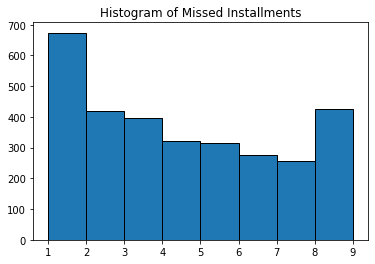

In [0]:
bins= [1,2,3,4,5,6,7,8,9]
plt.hist(instal['INSTALLMENTS_MISSED'], bins=bins, edgecolor="k")
plt.xticks(bins)
plt.title('Histogram of Missed Installments')
plt.show()

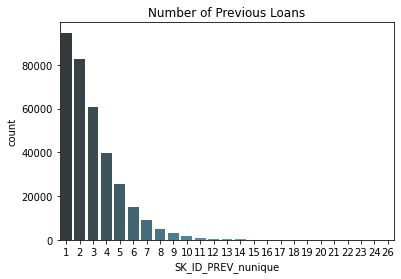

In [0]:
ax = sns.countplot(x="SK_ID_PREV_nunique", data=instal, palette="GnBu_d").set(title="Number of Previous Loans")

### Target Corelation

In [0]:
instalTrain = instal.set_index('SK_ID_CURR').join(other1.set_index('SK_ID_CURR'))

In [0]:
correlations = instalTrain.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 NUM_INSTALMENT_NUMBER_max         0.006304
AMT_INSTALMENT_nunique            0.009646
PAYMENT_DELAY_std                 0.009860
SK_ID_PREV_min                    0.017409
AMT_PAYMENT_nunique               0.024185
INSTALLMENT_DIFFERENCE_nunique    0.026795
LATE_PAYMENT_nunique              0.036174
INSTALLMENTS_MISSED               0.041861
LATE_PAYMENT_std                  0.053619
TARGET                            1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 DAYS_ENTRY_PAYMENT_max    -0.058795
DAYS_INSTALMENT_max       -0.058647
LATE_PAYMENT_mean         -0.051083
DAYS_ENTRY_PAYMENT_mean   -0.043991
DAYS_INSTALMENT_mean      -0.043508
DAYS_ENTRY_PAYMENT_sum    -0.038162
DAYS_INSTALMENT_sum       -0.037784
LATE_PAYMENT_min          -0.036547
LATE_PAYMENT_sum          -0.035991
SK_ID_PREV_nunique        -0.032745
Name: TARGET, dtype: float64


# Feature Engineering

In [0]:
for ds_name in ds_names:
    del datasets[ds_name]
    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


application_train: shape is (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,reg oper account,block of flats,0.014900,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,reg oper account,block of flats,0.071411,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


application_test: shape is (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018845,-19241,-2329,-5168.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752441,0.789551,0.159546,0.065979,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.050507,NaN,NaN,0.067200,0.061188,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.052612,NaN,NaN,0.066589,0.058990,0.973145,NaN,NaN,NaN,0.137939,0.125,NaN,NaN,NaN,0.051392,NaN,NaN,NaN,block of flats,0.039215,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035797,-18064,-4469,-9120.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564941,0.291748,0.432861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019104,-20038,-4458,-2176.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699707,0.610840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secon

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


bureau: shape is (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


bureau_balance: shape is (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%


credit_card_balance: shape is (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,1800.0,1800.0,0.000000,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,2250.0,2250.0,60175.078125,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,2250.0,2250.0,26926.425781,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,11925.0,11925.0,224949.281250,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,27000.0,27000.0,443044.406250,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


installments_payments: shape is (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


previous_application: shape is (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


POS_CASH_balance: shape is (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [0]:
dfDropCols = pd.read_csv('/content/drive/My Drive/HCDR/dropCols.csv')
#dfDropCols = pd.read_csv("D:\MS_DS\github\I526_AML_SP19\Assignments\Data\dropCols.csv")
print(len(dfDropCols))

166


### Feature Transformer Application Train/Test

In [0]:
class applTrans(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        cols_to_keep = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','REGION_RATING_CLIENT_W_CITY','DAYS_BIRTH',
                        'REGION_RATING_CLIENT','REG_CITY_NOT_WORK_CITY','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE',
                        'NAME_CONTRACT_TYPE','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_GOODS_PRICE','DAYS_EMPLOYED',
                        'DAYS_LAST_PHONE_CHANGE','DAYS_REGISTRATION','FLAG_DOCUMENT_3','FLOORSMAX_AVG','CNT_FAM_MEMBERS',
                        'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK',
                        'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR',
                        'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE',
                        'AMT_INCOME_TOTAL','OWN_CAR_AGE','AMT_CREDIT','AMT_ANNUITY','CODE_GENDER','SK_ID_CURR']
        

 
        encdr = LabelEncoder()
        df = pd.DataFrame(X,columns=cols_to_keep)
        day_convert(df)

        encdr_cols = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_DOCUMENT_3','CODE_GENDER'
                    ,'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS','OCCUPATION_TYPE','NAME_INCOME_TYPE']
        
        num_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY']
        
        #Update to remove incorrect values from Days Employed
        df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243,np.nan)
        
        df[num_cols] = df[num_cols].fillna(0,inplace=True)
        df[encdr_cols] = df[encdr_cols].fillna('Missing',inplace=True)
        
        # convert the birth_days to years
        df['YEARS_BIRTH']=(df['DAYS_BIRTH']/-365)
       # df['YEARS_BIRTH']=df['YEARS_BIRTH'].astype(int)
        # convert the days_employed to years
        df['YEARS_EMPLOYED']=(df['DAYS_EMPLOYED']/-365)
       # df['YEARS_EMPLOYED']=df['YEARS_EMPLOYED'].astype(int)
        

        df['INCOME_ANNUITY_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
        df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (1 + df['AMT_INCOME_TOTAL'])
        df['CREDIT_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
        df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
        df['DOWN_PAYMENT'] = df['AMT_GOODS_PRICE'] - df['AMT_CREDIT']
        df['PERC_LIFE_EMPLOYED'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
        
            
        #BUREAU Enquiries in an year
        df['ENQUIRIES_IN_AN_YEAR'] = df['AMT_REQ_CREDIT_BUREAU_HOUR'] + df['AMT_REQ_CREDIT_BUREAU_DAY'] + \
                                    df['AMT_REQ_CREDIT_BUREAU_WEEK'] + df['AMT_REQ_CREDIT_BUREAU_MON'] + \
                                    df['AMT_REQ_CREDIT_BUREAU_QRT'] + df['AMT_REQ_CREDIT_BUREAU_YEAR']
        
        for col in encdr_cols:
            lbl_cat = df[col]
            lbl_cat_encd = encdr.fit_transform(lbl_cat)
            df[col] = lbl_cat_encd
            
        df.drop(['AMT_REQ_CREDIT_BUREAU_HOUR','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_BIRTH','DAYS_EMPLOYED',
                    'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON',
                    'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','CNT_FAM_MEMBERS'],axis=1,inplace=True)
            
        df.fillna(0, inplace =  True)

        return df

### Feature Transformer Credit Card Data

In [0]:
class CCFeatAggr(BaseEstimator, TransformerMixin):
  def __init__(self, features=None):
    self.features = features

  def fit(self, X, y=None):
    return self
    
  def transform(self, X, y=None):
    df = pd.DataFrame(X,columns=self.features)
    # Convert day to postive values
    day_convert(df)
    # Total Spent Previous Month
    df['TOTAL_SPENT_PREV_MONTH'] = df["AMT_DRAWINGS_ATM_CURRENT"] + df["AMT_DRAWINGS_CURRENT"] + \
            df["AMT_DRAWINGS_OTHER_CURRENT"] + df["AMT_DRAWINGS_POS_CURRENT"]
    
    df['CREDIT_LEFT_PREV_MONTH']=df['AMT_CREDIT_LIMIT_ACTUAL']-df['TOTAL_SPENT_PREV_MONTH']

    
    # Fill missing numeric values with 0
    df = df.fillna(0)
        
    mean_sum = ['AMT_BALANCE','MONTHS_BALANCE']
    mean_only = ['TOTAL_SPENT_PREV_MONTH','CREDIT_LEFT_PREV_MONTH','CNT_INSTALMENT_MATURE_CUM','AMT_RECIVABLE',
                 'CNT_DRAWINGS_CURRENT','CNT_DRAWINGS_ATM_CURRENT','AMT_TOTAL_RECEIVABLE','AMT_RECEIVABLE_PRINCIPAL',
                'AMT_PAYMENT_CURRENT','CNT_DRAWINGS_OTHER_CURRENT']
    
    max_mean_sum = ['SK_DPD', 'SK_DPD_DEF']
      
    agg_op_features = {}
      
    for f in mean_sum:
      agg_op_features[f] = ['mean', 'sum']
        
    for f in max_mean_sum:
      agg_op_features[f] = ['max','mean','sum']

    for f in mean_only:
      agg_op_features[f] = ['mean']

    ccApp = df.groupby('SK_ID_CURR').agg(agg_op_features)
    ccApp.columns = ccApp.columns.map('_'.join)
    ccApp = ccApp.reset_index(level=["SK_ID_CURR"])
            
    #Fill NAs incase division resulted in NaN
    ccApp = ccApp.fillna(0)
    del df    
    return ccApp

In [0]:
class ccOHE(BaseEstimator, TransformerMixin):
    
     def __init__(self, features=None):
        self.features = features
    
     def fit(self, X, y=None):
        return self
    
     def transform(self,X):
        
        df = pd.DataFrame(X,columns=self.features)
        df['INSTALLMENT_TIME']=["OnTimePayment" if x <= 0 else "LatePayment" for x in df['SK_DPD']]
        df['MIN_PAID']=["PAID_MIN_BAL" if x >= 0 else "NOT_PAID_MIN_BAL" for x in (df['AMT_PAYMENT_TOTAL_CURRENT'] - df['AMT_INST_MIN_REGULARITY'])]
        
        df['NAME_CONTRACT_STATUS'] = df['NAME_CONTRACT_STATUS'].replace(["Demand","Signed","Approved",\
                                                                "Sent proposal", "Refused"],"Other")
        df = df.fillna(0)
        cat = ['NAME_CONTRACT_STATUS','INSTALLMENT_TIME','MIN_PAID']
        catEncoder = OneHotEncoder(handle_unknown='ignore')
        oheVar = catEncoder.fit_transform(df[cat])
        labels,values = catEncoder.categories_,oheVar.toarray()
        labels = np.concatenate(labels).ravel().tolist()
        df[labels] = pd.DataFrame(values)
        df = df.drop(['NAME_CONTRACT_STATUS','INSTALLMENT_TIME','MIN_PAID','SK_DPD','AMT_PAYMENT_TOTAL_CURRENT','AMT_INST_MIN_REGULARITY'],axis=1)

        ccApp = df.groupby(['SK_ID_CURR']).agg('max')

        ccApp = ccApp.reset_index(level=["SK_ID_CURR"])

        del df
        return ccApp

### Feature Transformer Bureau and Bureau Balances

In [0]:
class BurBalOHE (BaseEstimator,TransformerMixin):
  def __init__(self, features=None):
    self.features = features
    self.agg_op_features = {}

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    status_dict= {'C': 'CLOSED', 'X': 'UNKOWN', 0: 'UP_TO_30_MONTHS', 1: '31_TO_60_MONTHS', 2: '61_TO_90_MONTHS', 4: '91_TO_120_MONTHS', 5: '120+_MONTHS_OR_CLOSED'}
    for i in status_dict:
      X[status_dict[i]]= np.where(X["STATUS"].str.contains(str(i)), 1,0)
    newestbaldf = X.loc[X['MONTHS_BALANCE'] == -1]
    maxbaldf = X.groupby(['SK_ID_BUREAU']).agg(['max'])
    maxbaldf.columns = [ '_'.join(str(i) for i in col) for col in maxbaldf.columns]
    maxbaldf.reset_index(inplace=True)
    bureaubal= newestbaldf.set_index('SK_ID_BUREAU').join(maxbaldf.set_index('SK_ID_BUREAU'))
    del maxbaldf
    del newestbaldf
    return bureaubal

In [0]:
class BureauOHE(BaseEstimator,TransformerMixin):
  def __init__(self, features=None):
    self.features = features

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    bureau = pd.DataFrame(X)
    bureau['CREDIT_TYPE'] = bureau['CREDIT_TYPE'].replace(['Loan for working capital replenishment', 'Loan for business development', 'Real estate loan', 'Unknown type of loan','Another type of loan', 'Cash loan (non-earmarked)',
                                       'Loan for the purchase of equipment', 'Mobile operator loan', 'Interbank credit', 'Loan for purchase of shares (margin lending)'],'Other')
    cat = ['CREDIT_TYPE', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY']
    catEncoder = OneHotEncoder(handle_unknown='ignore')
    oheVar = catEncoder.fit_transform(bureau[cat])
    labels,values = catEncoder.categories_,oheVar.toarray()
    labels = np.concatenate(labels).ravel().tolist()
    bureau[labels] = pd.DataFrame(values)
    bureau = bureau.groupby('SK_ID_CURR').agg('sum')
    bureau = bureau.reset_index(level=["SK_ID_CURR"])
    return bureau


In [0]:
class BureauFeatAggr(BaseEstimator, TransformerMixin):
  def __init__(self, features=None):
    self.features = features

  def fit(self, X, y=None):
    return self
    
  def transform(self, X, y=None):
    df = pd.DataFrame(X,columns=self.features)
    # Convert day to postive values
    day_convert(df)
    # Fill missing Days on Entry with Days of Installment        
    mean_sum = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
           'AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE']
    cnt_feat = ['SK_ID_CURR', 'AMT_ANNUITY']
    std_feat = ['DAYS_CREDIT_ENDDATE']
      
    agg_op_features = {}
      
    for f in mean_sum:
      agg_op_features[f] = ['mean', 'sum', 'max']
        
    for f in cnt_feat:
      agg_op_features[f] = ['count']

    for f in std_feat:
      agg_op_features[f] = ['std']

    bureau = df.groupby('SK_ID_CURR').agg(agg_op_features)
    bureau.columns = bureau.columns.map('_'.join)
    bureau = bureau.reset_index(level=["SK_ID_CURR"])        
    #Fill NAs incase division resulted in NaN
    bureau = bureau.fillna(0)
    del df  
    return bureau

### Feature Transformer POS CASH

In [0]:
class PosCashOHE(BaseEstimator, TransformerMixin):
    
     def __init__(self, features=None):
        self.features = features
    
     def fit(self, X, y=None):
        return self
    
     def transform(self,X):
        
        df = pd.DataFrame(X,columns=self.features)
        
        X['NAME_CONTRACT_STATUS'] = X['NAME_CONTRACT_STATUS'].replace(["Demand","Returned to the store",\
                                                         "Approved","Amortized debt", "Canceled","XNA"],"Other")
        
        encdr = LabelEncoder()
        encdr_cols = ['NAME_CONTRACT_STATUS']
        
        df[encdr_cols] = df[encdr_cols].fillna('Missing')
        
        for col in encdr_cols:
            lbl_cat = df[col]
            lbl_cat_encd = encdr.fit_transform(lbl_cat)
            df[col] = lbl_cat_encd
        

        df = df.groupby(["SK_ID_CURR"]).count()[["NAME_CONTRACT_STATUS"]]
        
        return df

In [0]:
class PosCashFeatAggr(BaseEstimator, TransformerMixin):
    
     def __init__(self, features=None):
        self.features = features
    
     def fit(self, X, y=None):
        return self
    
     def transform(self,X):
        df = pd.DataFrame(X,columns=self.features)
        df.fillna(0)
        df["PAYMENTS_MADE"] = df["CNT_INSTALMENT"] - df["CNT_INSTALMENT_FUTURE"]
        df['ONTIME_PAYMENT']=[1 if x <= 0 else 0 for x in df['SK_DPD']]
        df['LATE_PAYMENT']=[0 if x <= 0 else 1 for x in df['SK_DPD']]
        aggs_opp = {}

        uniqcnts = ['SK_ID_PREV']
        mean_sum = ['CNT_INSTALMENT','PAYMENTS_MADE','MONTHS_BALANCE','SK_DPD','SK_DPD_DEF','CNT_INSTALMENT_FUTURE']
        max_only =  ['ONTIME_PAYMENT','LATE_PAYMENT']
        
        for f in uniqcnts:
            aggs_opp[f] = ['nunique']
        for f in mean_sum:
            aggs_opp[f] = ['mean','sum']
        for f in max_only:
            aggs_opp[f] = ['max']
            
        poscashApp = df.groupby(['SK_ID_CURR']).agg(aggs_opp)
        poscashApp.columns = poscashApp.columns.map('_'.join)
        poscashApp = poscashApp.reset_index(level=["SK_ID_CURR"])
        poscashApp = poscashApp.fillna(0)
            
        #self.fit(poscashApp)
        del df 
        return poscashApp

### Feature Transformer Previous Applications

In [0]:
class PrevAppFeatAggr(BaseEstimator, TransformerMixin):
    
     def __init__(self, features=None):
        self.features = features
    
     def fit(self, X, y=None):
        return self
    
     def transform(self,X):
        df = pd.DataFrame(X,columns=self.features)
        
        df['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
        df['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
        df['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
        df['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
        df['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
 
        df.fillna(0)                

        #df['REQ_APP_DIFF'] = df['AMT_APPLICATION'] - df['AMT_CREDIT']
        df['APP_CREDIT_PERC'] = df['AMT_APPLICATION'] / df['AMT_CREDIT']
        aggs_opp = {}
        min_max = ['AMT_ANNUITY']
        mean_sum = ['HOUR_APPR_PROCESS_START','CNT_PAYMENT','RATE_INTEREST_PRIVILEGED','RATE_DOWN_PAYMENT',
                    'DAYS_LAST_DUE_1ST_VERSION' ,'DAYS_FIRST_DUE','DAYS_DECISION', 'DAYS_FIRST_DRAWING',
                    'DAYS_TERMINATION','DAYS_LAST_DUE','AMT_CREDIT','AMT_DOWN_PAYMENT','AMT_GOODS_PRICE']
        max_min_mean = ['APP_CREDIT_PERC','AMT_APPLICATION']
        count_only = ['AMT_APPLICATION']
        sum_only = ['AMT_APPLICATION']
            
        for f in min_max:
            aggs_opp[f] = ['min','max']
        for f in mean_sum:
            aggs_opp[f] = ['mean','sum']
        for f in count_only:
            aggs_opp[f] = ['count']
        for f in sum_only:
            aggs_opp[f] = ['sum']
        for f in max_min_mean:
            aggs_opp[f] = ['max','min','mean']
            
        prevApp = df.groupby(['SK_ID_CURR']).agg(aggs_opp)
        prevApp.columns = prevApp.columns.map('_'.join)
        prevApp = prevApp.reset_index(level=["SK_ID_CURR"])
        prevApp['APPL_RANGE'] = prevApp['AMT_APPLICATION_max'] - prevApp['AMT_APPLICATION_min']
        prevApp['AMT_ALLOCATION_DIFF'] = prevApp['AMT_CREDIT_mean'] - prevApp['AMT_APPLICATION_mean']
        prevApp = prevApp.fillna(0)
           
        del df  
        
        return prevApp

In [0]:
class prevApplLblEncdr(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        encdr_cols = ['NFLAG_INSURED_ON_APPROVAL','WEEKDAY_APPR_PROCESS_START',
                      'NAME_CASH_LOAN_PURPOSE', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE','NAME_YIELD_GROUP',
                      'NAME_CONTRACT_TYPE','NAME_CONTRACT_STATUS','NAME_TYPE_SUITE']
       
        df = pd.DataFrame(X,columns=self.features)
        
        encdr = LabelEncoder()
        df[encdr_cols] = df[encdr_cols].fillna('Missing',inplace=True)
        
        for col in encdr_cols:
            lbl_cat = df[col]
            lbl_cat_encd = encdr.fit_transform(lbl_cat)
            df[col] = lbl_cat_encd
            
        prevApp = df.groupby(['SK_ID_CURR']).agg('max')
        prevApp = prevApp.reset_index(level=["SK_ID_CURR"])
        
        return prevApp

### Feature Transformer Installments Payment

In [0]:
class InstallFeatAggr(BaseEstimator, TransformerMixin):
  def __init__(self, features=None):
    self.features = features

  def fit(self, X, y=None):
    return self
    
  def transform(self, X, y=None):
    df = pd.DataFrame(X,columns=self.features)
    # Convert day to postive values
    day_convert(df)
    # Fill missing Days on Entry with Days of Installment
    df['DAYS_ENTRY_PAYMENT'] = df['DAYS_ENTRY_PAYMENT'].fillna(df['DAYS_INSTALMENT'])
    # Fill missing numeric values with 0
    df = df.fillna(0)

    df['PAYMENT_DELAY']=df['DAYS_ENTRY_PAYMENT']-df['DAYS_INSTALMENT']
    df['PAYMENT_EARLY']=df['DAYS_INSTALMENT']-df['DAYS_ENTRY_PAYMENT']
    df['PAYMENT_DELAY'] = df['PAYMENT_DELAY'].apply(lambda x: x if x > 0 else 0)
    df['PAYMENT_EARLY'] = df['PAYMENT_EARLY'].apply(lambda x: x if x > 0 else 0)
    
    #Difference and Percent of Amount Paid and Installment 
    df['INSTALLMENT_DIFFERENCE']=df['AMT_INSTALMENT'] - df['AMT_PAYMENT']
    df['INSTALLMENT_PER']=df['AMT_PAYMENT'] / df['AMT_INSTALMENT']
    
    mean_sum = ['AMT_INSTALMENT', 'AMT_PAYMENT','DAYS_ENTRY_PAYMENT','PAYMENT_EARLY',
                'PAYMENT_DELAY','INSTALLMENT_DIFFERENCE','INSTALLMENT_PER']
    cnt_feat = ['SK_ID_CURR']
    uni_feat = ['SK_ID_PREV']
    max_feat = ['NUM_INSTALMENT_NUMBER','DAYS_ENTRY_PAYMENT']
      
    agg_op_features = {}
      
    for f in mean_sum:
      agg_op_features[f] = ['mean', 'sum']
        
    for f in cnt_feat:
      agg_op_features[f] = ['count']

    for f in max_feat:
      agg_op_features[f] = ['max']
    
    for f in uni_feat:
      agg_op_features[f] = ['nunique']

    instal = df.groupby('SK_ID_CURR').agg(agg_op_features)
    instal.columns = instal.columns.map('_'.join)
    instal = instal.reset_index(level=["SK_ID_CURR"])

    # Create a new feature - Number of missed installments -> Max Install number - total intallment count
    instal['INSTALLMENTS_MISSED']=instal['NUM_INSTALMENT_NUMBER_max'] - instal['SK_ID_CURR_count']
            
    #Fill NAs incase division resulted in NaN
    instal = instal.fillna(0)
    del df    
    return instal

# Pipelines

## Preprocessing Pipelines

### Application Train Pipeline

In [0]:
print("Application Train Data")

apl_pipeline = Pipeline([
    ('applXfrm',applTrans()),
    #('applTrain',applXfrmr()),
    #('encoder',applLblEncdr()),
    ])

Application Train Data


### Installments Payments Pipeline

In [0]:
%%time
print("Installments Payment Pipeline")
insDF_feature_pipeline = Pipeline([
    ('installAggr',InstallFeatAggr())
    ])
insDF_aggregated = insDF_feature_pipeline.fit_transform(datasets["installments_payments"])

Installments Payment Pipeline
CPU times: user 21.1 s, sys: 318 ms, total: 21.4 s
Wall time: 21.3 s


### Previous Applications Pipeline

In [0]:
%%time
print("Previous Application Pipeline")
num_col = ['SK_ID_CURR','AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
           'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'CNT_PAYMENT',
           'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
           'DAYS_TERMINATION', 'HOUR_APPR_PROCESS_START', 'DAYS_DECISION']

cat_col = ['NFLAG_INSURED_ON_APPROVAL','WEEKDAY_APPR_PROCESS_START', 
           'NAME_CASH_LOAN_PURPOSE', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE','NAME_YIELD_GROUP',
           'NAME_CONTRACT_TYPE','NAME_TYPE_SUITE','SK_ID_CURR', 'NAME_CONTRACT_STATUS']

prevDF_cat_pipeline = Pipeline([
    ('dfSelector',DataFrameSelector(cat_col)),
    #('prevOHE',PrevApplOHE()),
    ('prevLBLEncdr',prevApplLblEncdr())
    ])

prevDF_num_pipeline = Pipeline([
    ('dfSelector',DataFrameSelector(num_col)),
    ('prevFeatAggr',PrevAppFeatAggr())
    ])

prevDF_cat = prevDF_cat_pipeline.fit_transform(datasets["previous_application"])
prevDF_num = prevDF_num_pipeline.fit_transform(datasets["previous_application"])
prevDF_aggregated = prevDF_cat.merge(prevDF_num,left_on="SK_ID_CURR",right_on="SK_ID_CURR")
del prevDF_cat
del prevDF_num

Previous Application Pipeline
CPU times: user 6.07 s, sys: 79.9 ms, total: 6.15 s
Wall time: 6.14 s


### Credit Card Pipeline

In [0]:
%%time
print("Credit Card Pipeline")
cat_col = ['SK_ID_CURR','NAME_CONTRACT_STATUS','SK_DPD','AMT_PAYMENT_TOTAL_CURRENT','AMT_INST_MIN_REGULARITY']

num_col = ['SK_ID_CURR','AMT_DRAWINGS_ATM_CURRENT','AMT_DRAWINGS_CURRENT','AMT_DRAWINGS_OTHER_CURRENT',
           'MONTHS_BALANCE','SK_DPD','SK_DPD_DEF','AMT_DRAWINGS_POS_CURRENT','AMT_CREDIT_LIMIT_ACTUAL',
           'AMT_BALANCE','CNT_INSTALMENT_MATURE_CUM','AMT_PAYMENT_TOTAL_CURRENT','CNT_DRAWINGS_CURRENT',
           'CNT_DRAWINGS_ATM_CURRENT','AMT_TOTAL_RECEIVABLE','AMT_RECIVABLE','AMT_RECEIVABLE_PRINCIPAL',
          'AMT_PAYMENT_CURRENT','CNT_DRAWINGS_OTHER_CURRENT']

ccDF_cat_pipeline = Pipeline([
    ('dfSelector',DataFrameSelector(cat_col)),
    ('ccOHE',ccOHE())
    ])

ccDF_num_pipeline = Pipeline([
    ('dfSelector',DataFrameSelector(num_col)),
    ('CCFeatAggr',CCFeatAggr())
    ])

ccDF_cat = ccDF_cat_pipeline.fit_transform(datasets["credit_card_balance"])
ccDF_num = ccDF_num_pipeline.fit_transform(datasets["credit_card_balance"])
ccDF_aggregated = ccDF_num.merge(ccDF_cat,left_on="SK_ID_CURR",right_on="SK_ID_CURR")
del ccDF_num
del ccDF_cat

Credit Card Pipeline
CPU times: user 7.06 s, sys: 29.9 ms, total: 7.09 s
Wall time: 7.06 s


### POS Cash Pipeline

In [0]:
%%time
print("Pos Cash Pipeline")
cat_col = ['SK_ID_CURR','NAME_CONTRACT_STATUS']

num_col = ['SK_ID_CURR','SK_ID_PREV','CNT_INSTALMENT','CNT_INSTALMENT_FUTURE','MONTHS_BALANCE','SK_DPD','SK_DPD_DEF']

posCashDF_cat_pipeline = Pipeline([
    ('dfSelector',DataFrameSelector(cat_col)),
    ('poscashOHE',PosCashOHE())
    ])

posCashDF_num_pipeline = Pipeline([
    ('dfSelector',DataFrameSelector(num_col)),
    ('poscashFeatAggr',PosCashFeatAggr())
    ])

posCashDF_cat = posCashDF_cat_pipeline.fit_transform(datasets["POS_CASH_balance"])
posCashDF_num = posCashDF_num_pipeline.fit_transform(datasets["POS_CASH_balance"])
posCashDF_aggregated = posCashDF_num.merge(posCashDF_cat,left_on="SK_ID_CURR",right_on="SK_ID_CURR")
del posCashDF_num
del posCashDF_cat

Pos Cash Pipeline
CPU times: user 21.3 s, sys: 63.5 ms, total: 21.4 s
Wall time: 21.3 s


### Bureau Pipeline

In [0]:
cat_col = ['SK_ID_CURR','CREDIT_TYPE', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CLOSED',
           'UNKOWN', 'UP_TO_30_MONTHS','31_TO_60_MONTHS', '61_TO_90_MONTHS',
           '91_TO_120_MONTHS','120+_MONTHS_OR_CLOSED','MONTHS_BALANCE_max',
           'STATUS_max', 'CLOSED_max', 'UNKOWN_max',
           'UP_TO_30_MONTHS_max', '31_TO_60_MONTHS_max', '61_TO_90_MONTHS_max',
           '91_TO_120_MONTHS_max', '120+_MONTHS_OR_CLOSED_max']
num_col = ['SK_ID_CURR','DAYS_CREDIT','CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
           'AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT','AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

In [0]:
%%time
# In order for to incorporate bureau balance, it must be combined before the bureau pipelines
print("Bureau Balance Pipeline")
bureau= datasets["bureau"]
bureau_bal_feature_pipeline= Pipeline([ 
    ('BalBur', BurBalOHE())
    ])
bureaubal=bureau_bal_feature_pipeline.fit_transform(datasets['bureau_balance'])
bureauMerge = bureau.merge(bureaubal,left_on="SK_ID_BUREAU",right_on="SK_ID_BUREAU")

Bureau Balance Pipeline
CPU times: user 2min 39s, sys: 2.17 s, total: 2min 41s
Wall time: 2min 39s


In [0]:
%%time
print("Bureau Pipeline")

bureau_cat_pipeline = Pipeline([
    ('prevLBLEncdr',BureauOHE())
    ])

bureau_num_pipeline = Pipeline([
    ('prevFeatAggr',BureauFeatAggr())
    ])


bureau_cat = bureau_cat_pipeline.fit_transform(bureauMerge[cat_col])
bureau_num = bureau_num_pipeline.fit_transform(bureauMerge[num_col])
bureauDF = bureau_cat.merge(bureau_num,left_on="SK_ID_CURR",right_on="SK_ID_CURR")
del bureau_cat
del bureau_num
del bureaubal
del bureauMerge

Bureau Pipeline
CPU times: user 1.93 s, sys: 13.9 ms, total: 1.95 s
Wall time: 1.95 s


In [0]:
# Check the shape of the resulting data sets
print("Previous Appl", prevDF_aggregated.shape)
print("Installments", insDF_aggregated.shape)
print("POS CASH", posCashDF_aggregated.shape)
print("Credit Cards", ccDF_aggregated.shape)
print("Bureau", bureauDF.shape)

Previous Appl (338857, 46)
Installments (339587, 18)
POS CASH (337252, 17)
Credit Cards (103558, 28)
Bureau (130176, 63)


In [0]:
# To write the file to the disk
#X_train.to_csv("/content/drive/My Drive/HCDR/X_train.csv", index=False) 

NameError: ignored

In [0]:
# To write the file to the disk
#X_test.to_csv('/content/drive/My Drive/HCDR/X_test.csv', index=False) 

## Data Preparation

### Merge

In [0]:
#dflist = (insDF_aggregated,posCashDF_aggregated,ccDF_aggregated,prevDF_aggregated,bureauDF)
dflist = (prevDF_aggregated,ccDF_aggregated,posCashDF_aggregated,bureauDF,insDF_aggregated)

In [0]:
X_train_full = datasets["application_train"]
X_Kaggle_test = datasets["application_test"]

In [0]:
y_train_full = X_train_full['TARGET']
X_train_full = X_train_full.drop(columns=['TARGET'])

In [0]:
data_merge_pipeline = Pipeline([
    ('applData',apl_pipeline),
    ('mergeData',mergeData(dflist)),
    ])

In [0]:
%%time
X_train_full = data_merge_pipeline.fit_transform(X_train_full)
X_Kaggle_test = data_merge_pipeline.fit_transform(X_Kaggle_test)

CPU times: user 8.2 s, sys: 77.8 ms, total: 8.28 s
Wall time: 8.28 s


In [0]:
# Drop all original dataframes to save on memory
ds_drop= {}
ds_drop = ("application_train", "application_test", "bureau","bureau_balance","credit_card_balance","installments_payments",
            "previous_application","POS_CASH_balance")
#for dname in ds_drop:
#    datasets[dname] = None
#    del datasets[dname]

In [0]:
X_train_full.memory_usage().head()

Index                          2460088
EXT_SOURCE_1                    615022
EXT_SOURCE_2                    615022
EXT_SOURCE_3                    615022
REGION_RATING_CLIENT_W_CITY     307511
dtype: int64

In [0]:
X_train_full.duplicated(subset='SK_ID_CURR').sum()

0

In [0]:
X_Kaggle_test.duplicated(subset='SK_ID_CURR').sum()

0

In [0]:
X_train_full = X_train_full.drop(columns=['SK_ID_CURR'])
X_Kaggle_test = X_Kaggle_test.drop(columns=['SK_ID_CURR'])

In [0]:
selected_columns = list(X_train_full.columns)
len(selected_columns)

201

### Train, Test, Validation Split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [0]:
print(f"X train           shape: {X_train.shape}")
print(f"X validation      shape: {X_valid.shape}")
print(f"X test            shape: {X_test.shape}")
print(f"X X_Kaggle_test   shape: {X_Kaggle_test.shape}")

X train           shape: (222176, 201)
X validation      shape: (46127, 201)
X test            shape: (39208, 201)
X X_Kaggle_test   shape: (48744, 201)


In [0]:
data_prep_pipeline = Pipeline([
        ('selector', DataFrameSelector(selected_columns)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])

# Baseline Model

To get a baseline, we will use some of the features after being preprocessed through the pipeline.
The baseline model is a logistic regression model

## Evaluation metrics
Submissions are evaluated on [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic) between the predicted probability and the observed target.

The SkLearn `roc_auc_score` function computes the area under the receiver operating characteristic (ROC) curve, which is also denoted by AUC or AUROC. By computing the area under the roc curve, the curve information is summarized in one number. 

```python
from sklearn.metrics import roc_auc_score
>>> y_true = np.array([0, 0, 1, 1])
>>> y_scores = np.array([0.1, 0.4, 0.35, 0.8])
>>> roc_auc_score(y_true, y_scores)
0.75
```

In [0]:
from scipy import stats

def pct(x):
    return round(100*x,3)

In [0]:
try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["exp_name", 
                                   "Train Acc", 
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train AUC", 
                                   "Valid AUC",
                                   "Test  AUC"
                                  ])


## Logistic Regression

In [0]:
%%time 
np.random.seed(42)
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("linear", LogisticRegression())
    ])
model = full_pipeline_with_predictor.fit(X_train, y_train)


CPU times: user 22.4 s, sys: 6.49 s, total: 28.9 s
Wall time: 8.54 s


In [0]:
logit_scores= np.round(accuracy_score(y_train, model.predict(X_train)), 3)
logit_scores

0.92

In [0]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.7415716715761076

In [0]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.739849948542758

In [0]:
exp_name = f"Baseline_{len(selected_columns)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test, model.predict(X_test)),
                roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])],
    4)) 
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
0,Baseline_201_features,0.9197,0.9195,0.9158,0.7416,0.7427,0.7398


## XGBoost

In [0]:
%%time 
np.random.seed(42)
full_pipeline_XGB = Pipeline([
        ("preparation", data_prep_pipeline),
        ("xgboost",XGBClassifier())
    ])
model = full_pipeline_XGB.fit(X_train, y_train)

CPU times: user 2min 4s, sys: 343 ms, total: 2min 4s
Wall time: 2min 4s


In [0]:
np.round(accuracy_score(y_train, model.predict(X_train)), 3)

0.92

In [0]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.768493686026597

In [0]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7554939809235046

In [0]:
exp_name = f"Baseline_XGB_{len(selected_columns)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test, model.predict(X_test)),
                roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])],
    4)) 
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
0,Baseline_201_features,0.9197,0.9195,0.9158,0.7416,0.7427,0.7398
1,Baseline_XGB_201_features,0.9200,0.9197,0.9160,0.7685,0.7555,0.7577


## Light GBM

In [0]:
%%time 
np.random.seed(42)
full_pipeline_LGB = Pipeline([
        ("preparation", data_prep_pipeline),
        ("lgb",LGBMClassifier(n_estimators=1300,n_jobs = -1, max_depth=25, num_leaves=5))
    ])
model = full_pipeline_LGB.fit(X_train, y_train)

CPU times: user 2min 36s, sys: 104 ms, total: 2min 36s
Wall time: 2min 36s


In [0]:
np.round(accuracy_score(y_train, model.predict(X_train)), 3)

0.922

In [0]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.8241787978714916

In [0]:
roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])

0.7674953946691904

In [0]:
exp_name = f"Baseline_LGB_{len(selected_columns)}_features"
expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
               [accuracy_score(y_train, model.predict(X_train)), 
                accuracy_score(y_valid, model.predict(X_valid)),
                accuracy_score(y_test, model.predict(X_test)),
                roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])],
    4)) 
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
0,Baseline_201_features,0.9197,0.9195,0.9158,0.7416,0.7427,0.7398
1,Baseline_XGB_201_features,0.9200,0.9197,0.9160,0.7685,0.7555,0.7577
2,Baseline_LGB_201_features,0.9223,0.9199,0.9160,0.8242,0.7675,0.7696


In [0]:
expLog.to_csv("expLog1.csv", index=False)

## Neural Network

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.30, random_state=42)

In [0]:
model = Sequential()
model.add(Dense(64, input_dim=201, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                12928     
_________________________________________________________________
dense_17 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 13,985
Trainable params: 13,985
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=25 )

Epoch 1/10
215257/215257 [==============================] - 23s 107us/step - loss: 0.7532 - accuracy: 0.9188
Epoch 2/10
215257/215257 [==============================] - 23s 106us/step - loss: 0.3819 - accuracy: 0.9191
Epoch 3/10
215257/215257 [==============================] - 24s 109us/step - loss: 0.3706 - accuracy: 0.9191
Epoch 4/10
215257/215257 [==============================] - 23s 108us/step - loss: 0.2852 - accuracy: 0.9191
Epoch 5/10
215257/215257 [==============================] - 23s 107us/step - loss: 0.3048 - accuracy: 0.9191
Epoch 6/10
215257/215257 [==============================] - 23s 107us/step - loss: 0.2946 - accuracy: 0.9191
Epoch 7/10
215257/215257 [==============================] - 23s 107us/step - loss: 0.2809 - accuracy: 0.9191
Epoch 8/10
215257/215257 [==============================] - 23s 106us/step - loss: 0.2815 - accuracy: 0.9191
Epoch 9/10
215257/215257 [==============================] - 23s 105us/step - loss: 0.3553 - accuracy: 0.9191
Epoch 10/10
215257/

In [0]:
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

92254/92254 [==============================] - 3s 36us/step
Accuracy: 91.96


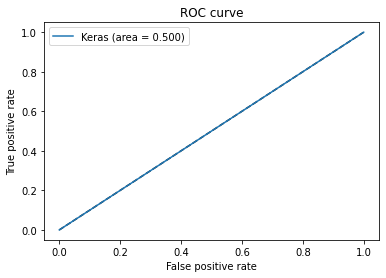

In [0]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Submission File Prep

For each SK_ID_CURR in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

```python 
SK_ID_CURR,TARGET
100001,0.1
100005,0.9
100013,0.2
etc.
```

In [0]:
test_class_scores = model.predict_proba(X_Kaggle_test)[:, 1]

IndexError: ignored

In [0]:
test_class_scores[0:10]

NameError: ignored

In [0]:
# Submission dataframe
submit_df = datasets["application_test"][['SK_ID_CURR']]
submit_df['TARGET'] = test_class_scores

submit_df.head()

In [0]:
submit_df.to_csv("submission.csv",index=False)

# Grid Search

In [0]:
rungs=False

In [0]:
from time import time
from sklearn.model_selection import cross_val_score, ShuffleSplit
cv30Splits = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy import stats

### XGBoost

In [0]:
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix='', n_jobs=-1,verbose=1):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('xgboost',XGBClassifier())
    ]

    params_grid = {
        'xgboost':{
            "learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
            "max_depth"     : [ 3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight" : [ 1, 3, 5, 7 ],
            "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] 
        }
     }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p]
        grid_search = RandomizedSearchCV(full_pipeline_with_predictor, params, n_iter=30, scoring='accuracy', cv=5, verbose=20, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Best estimator score
        best_train = pct(grid_search.best_score_)
        print("Best Train:", best_train)
        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)
        print("Train Time:", train_time)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)
        print("Test Time:", test_time)


        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring="accuracy", cv=cv30Splits)
        print("Best Train Scores:", best_train_scores)
        best_train_accuracy = pct(np.mean(best_train_scores))
        print("Best Train Accuracy:", best_train_accuracy)

   
        logit_scores= np.round(accuracy_score(y_test, grid_search.best_estimator_.predict(X_test)), 3)

        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, train_time, test_time, json.dumps(param_dump)]

In [0]:
# %%time
#print(time())
# This might take a while
if rungs:
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    # n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
    #
    # By default, the GridSearchCV uses a 3-fold cross-validation. However, if it 
    #            detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.
    ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:",  n_jobs=-1,verbose=1)

1588276036.6072898
****** START Best Model: xgboost *****
Parameters:
	colsample_bytree: [0.3, 0.4, 0.5, 0.7]
	gamma: [0.0, 0.1, 0.2, 0.3, 0.4]
	learning_rate: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
	max_depth: [3, 4, 5, 6, 8, 10, 12, 15]
	min_child_weight: [1, 3, 5, 7]
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

KeyboardInterrupt: ignored

### XGBoost Output



```
1587955001.3755856
****** START Best Model: xgboost *****
Parameters:
	colsample_bytree: [0.3, 0.4, 0.5, 0.7]
	gamma: [0.0, 0.1, 0.2, 0.3, 0.4]
	learning_rate: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
	max_depth: [3, 4, 5, 6, 8, 10, 12, 15]
	min_child_weight: [1, 3, 5, 7]
Fitting 5 folds for each of 30 candidates, totalling 150 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 38.3min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 41.2min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed: 47.0min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 48.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 50.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed: 57.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 58.9min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 58.9min
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 65.5min
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed: 69.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 69.6min
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed: 72.4min
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 73.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 75.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 76.2min
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed: 76.4min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 77.6min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed: 78.8min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 80.3min
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed: 85.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 86.2min
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed: 87.6min
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed: 91.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 102.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 103.4min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 104.6min
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed: 108.3min
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed: 112.6min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 113.8min
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed: 117.5min
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed: 119.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 121.7min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 122.8min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 128.6min
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed: 130.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 132.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 134.0min
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed: 139.8min
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed: 155.2min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed: 158.1min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed: 159.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 165.0min
[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed: 169.2min
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed: 170.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 176.2min
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed: 180.3min
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed: 180.4min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 181.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 189.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 193.1min
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed: 193.2min
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed: 193.9min
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed: 201.8min
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed: 205.4min
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed: 205.4min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed: 206.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 209.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 210.0min
[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed: 213.0min
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed: 213.8min
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed: 214.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 216.8min
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed: 217.7min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 222.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 222.5min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed: 225.3min
[Parallel(n_jobs=-1)]: Done  99 tasks      | elapsed: 226.2min
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed: 230.7min
[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed: 231.0min
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed: 234.0min
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed: 234.8min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 239.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 239.7min
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed: 239.7min
[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed: 240.5min
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed: 245.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 245.4min
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed: 245.4min
[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed: 251.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 256.1min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed: 256.5min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 256.6min
[Parallel(n_jobs=-1)]: Done 115 tasks      | elapsed: 260.6min
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed: 261.1min
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed: 261.2min
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed: 262.8min
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed: 264.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 265.1min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 265.6min
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed: 266.0min
[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed: 267.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 268.3min
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed: 268.8min
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed: 273.2min
[Parallel(n_jobs=-1)]: Done 127 tasks      | elapsed: 274.8min
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed: 275.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 276.0min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 280.4min
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed: 286.0min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 286.4min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 287.1min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 291.6min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 297.2min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 304.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 305.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 309.4min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 312.0min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 315.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 316.4min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 319.0min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 321.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 332.0min finished

Best Train: 91.97
Train Time: 122.6445
Test Time: 0.5842
Best Train Scores: [0.92139524 0.92116703 0.92020858 0.9209046  0.91935281 0.91959243
 0.9206764  0.91966089 0.9182118  0.91918166 0.91886218 0.91992332
 0.91781244 0.91838295 0.92007166 0.92056229 0.92139524 0.91817757
 0.9195582  0.92036832 0.9205737  0.91993473 0.9206764  0.91872525
 0.92029986 0.92106434 0.91877089 0.92056229 0.92118985 0.91871384]
Best Train Accuracy: 91.987
Best Parameters:
	predictor__colsample_bytree: 0.5
	predictor__gamma: 0.2
	predictor__learning_rate: 0.15
	predictor__max_depth: 6
	predictor__min_child_weight: 7
****** FINISH Best Model: xgboost  *****


```



### LightGBM 

In [0]:
def lgb_gridsearch_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=20
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [0]:

if rungs:
  X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
  X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]
  model = lgb.LGBMClassifier()
  param_grid = {
      'n_estimators': [1100, 1200, 1300, 1500],
      'max_depth': [10,15,20,25],
      'num_leaves': [200]
  }


  model, pred = gb_gridsearch_pipeline(x_train, x_test, y_train, y_test, model, 
                                  param_grid, cv=3, scoring_fit='roc_auc')

  print(model.best_score_)
  print(model.best_params_)

### LightGBM Output

This LightGBM Grid Search created following output. This model over fit the model with the number of leaves. The leaves had to be reduced with manual testing. 


```
Fitting 3 folds for each of 16 candidates, totalling 48 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 34.5min
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 52.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 53.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 55.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 67.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 67.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 69.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 72.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 85.0min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 85.5min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 88.2min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed: 90.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 104.3min
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed: 108.2min
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed: 109.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 111.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 120.5min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 124.2min
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed: 125.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 127.4min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 138.6min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 142.1min
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed: 144.6min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed: 145.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 158.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 164.9min
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed: 166.7min
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed: 167.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 174.4min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 181.2min
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed: 181.8min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 183.4min
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed: 191.8min
[Parallel(n_jobs=-1)]: Done  44 out of  48 | elapsed: 202.0min remaining: 18.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 221.5min finished

0.7451383824520795
{'max_depth': 25, 'n_estimators': 1300, 'num_leaves': 200}

```



# Kaggle submission via the command line API

In [0]:
! kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "baseline submission"

## report submission

Click on this [link](https://www.kaggle.com/c/home-credit-default-risk/submissions?sortBy=date&group=all&page=1)

![image.png](attachment:image.png)

# Write-up 
For this phase of the project, you will need to submit a write-up summarizing the work you did. 
The write-up form is available on Canvas (Modules-> Module 12.1 - Course Project - Home Credit Default Risk (HCDR)-> FP Phase 2 (HCDR) : write-up form ). It has the following sections: 
## Abstract
Home Credit is a non-banking financial institution that uses sources like transactional data and telecom data, to get insights into the applicant’s finances and determine their repayment capabilities and accordingly help them to obtain loans. These insights are to answer the biggest question the company has, will the applicant be able to repay the loan?

We were required to understand the dataset, extract relevant features, perform experiments using various machine learning algorithms and determine the best performing parameters.

We did EDA, visualize the data for better presentation, find the correlation between the various data elements, create new features from existing data, rollup and aggregate wherever necessary. All this was done using pipelines so that our solutions remain clean and reproducible.

We used a subset of available features, extracted additional features and ran through the models comprising Logistic Regression, XGABoost and LightGBM. We got the best Kaggle score of .767.

## Introduction

Home Credit share the data in 7 different files:

* __application_train/application_test:__ the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating __0: the loan was repaid__ or __1: the loan was not repaid__. The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.
* __bureau:__ data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* __bureau_balance:__ monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* __previous_application:__ previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* __POS_CASH_BALANCE:__ monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* __credit_card_balance:__ monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment:__ payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

## Feature Engineering and transformers

We created custom transformers for each of the datasets. There are Feature Aggregators, One Hot Encoders and Column Encoders depending on the need of the data. Once we had merged the data we had 200+ features. With experiments we were able to determine what features didnt help and we dropped those features. Below are the snapshots of some new features extracted from the Application data set and the transformer for the Bureau data:

![New_Features.JPG](attachment:New_Features.JPG)

![Transformer.JPG](attachment:Transformer.JPG)

## Pipelines

There are multiple pipelines created. There are individual pipelines for each data set that Encode and Aggregate the specific dataset. Thereafter we have the Data Merge Pipeline that transforms the application (test and train) datasets and merges them with each of the auxillary datasets resulting into 2 final datasets the X_train_full and X_Kaggle_test. The merge pipeline is invoked for both Test ad Train sets to make sure that same processing steps are applied on both the data sets.

Thereafter there is the Data Prep pipeline that users this data and runs the Standard Scaler process on it and imputer to fill the missing data. There are individual pipelines for each of the baseline models i.e. Logistic Regression, XGBoost and LightGBM that call the Data Prep Pipeline to get the train data.

In the pipeline code below one can see how one pipeline calls the other therefore making the code reliable and rerunnable:

* **Data Merge Pipeline**

`
data_merge_pipeline = Pipeline([
    ('applData',apl_pipeline),
    ('mergeData',mergeData(dflist)),
    ])
`
* **Full Pipeline for LGB**

`
full_pipeline_LGB = Pipeline([
        ("preparation", data_prep_pipeline),
        ("lgb",LGBMClassifier(n_estimators=1300,n_jobs = -1, max_depth=25, num_leaves=5))
    ])
`

## Experimental results
 Multiple experiments were performed. The team worked in parallel with one of the members working on feature engineering and passing the data depending on how the baseline tests go, to the team members doing the grid search narrowing down the best parameters. The results were logged and preserved. Below is the sample log:
 
 ![expLog.jpg](attachment:expLog.jpg)
 
 A csv file was generated and submitted to Kaggle and the reults recorded. Here is a sample of the submission:
 
 ![submission.png](attachment:submission.png)


## Discussion

We started the experiments with 200+ features however were seeing scores for roc and auc of around .7 . Thereafter we started with choosing as low as 14 features from the application data set and kept of adding existing features and adding new ones. Once we observed that the addition of features was not helping with the results improvement we merged the auxillary data sets one by one and were able to reach the score of .767.

The most time consuming task has been the feature engineering and the feature selection. Once we were able to build and wrap everything into pipelines the code became much simpler to maintain.

![Baseline_14_features.JPG](attachment:Baseline_14_features.JPG)

## Conclusion

We found that the following features have the most affect on determining whethere the customer should be granted the loan or not:

1. EXT_SOURCE_3
2. EXT_SOURCE_2
3. EXT_SOURCE_1
4. DAYS_BIRTH
5. REGION_RATING_CLIENT_W_CITY

With the customers mostly coming from a non banking background the external sources being the most affective factor is a reasonable conclusion. We also observed that including all features in our experiments does not neccessarily mean a better performing model. We got better results with the smaller set of data.

## Kaggle Submission


![Kaggle Submission](https://drive.google.com/uc?id=1CAAdcqN4FyhqC_X_6IOae-lhCfodg1HE)

# References

Some of the material in this notebook has been adopted from [here](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/notebook) and the code to reduce the memory footprint has been taken from [here](https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/)
